In [1]:
import pandas as pd
import numpy as np
import itertools
import warnings
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering, KMeans, OPTICS
import pyPLNmodels
from pyPLNmodels.models import PlnPCAcollection, Pln, ZIPln


#### Helpful Function

In [2]:
def create_metrics_cluster_df(df_cluster, df_scales):
    new_data = pd.merge(df_cluster, df_scales, left_on='Subject ID', right_on='EPRIME_CODE')

    filter_df = filter_data(new_data)

    data_clust = {}
    for clust in np.unique(filter_df["clusters"]):
        metric_data = {}
        for column in filter_df.drop(["EPRIME_CODE", "clusters"], axis=1).columns:
            mean_col = filter_df[filter_df["clusters"] == clust][column].mean()
            #std_col = filter_df[filter_df["clusters"] == clust][column].std()
            #max_col = filter_df[filter_df["clusters"] == clust][column].max()
            #min_col = filter_df[filter_df["clusters"] == clust][column].min()

            # Normality Test
            # _, p_value_col = stats.shapiro(result_df[result_df["clusters"]==clust][column])
            metric_data[column] = {'mean': round(mean_col, 2)}#, 'std': round(std_col, 2),
                                   #'max': max_col, 'min': min_col}

        data_clust[clust] = metric_data

    df_clusters = pd.DataFrame()
    for cluster, attributes in data_clust.items():
        for attribute, values in attributes.items():
            for stat, value in values.items():
                col_name = f"{attribute}_{stat}"
                df_clusters.loc[cluster, col_name] = value

    return df_clusters


def filter_data(df,data_type = np.number,na_number = 60):
    numeric_columns = df.select_dtypes(include=[data_type]).columns
    columns_to_select = ['EPRIME_CODE'] + list(numeric_columns)
    
    # Selecting all numeric columns along with "Subject"
    filtered_df = df[columns_to_select]
    cols_to_drop = filtered_df.columns[filtered_df.isnull().sum() >= na_number]
    filtered_df = filtered_df.drop(columns=cols_to_drop).copy()
    return filtered_df.drop("Age", axis=1)

def create_mean_tasks(df,df_cluster):

    copy_data = df.copy()
    copy_data["clusters"] = df_cluster["clusters"]
    
    # Extract cluster labels
    clusters = copy_data['clusters'].unique()
    
    # Create an empty DataFrame to store the mean scores
    df_mean_scores = pd.DataFrame(columns=['Cluster', 'Happy_0', 'Happy_1', 'Sad_0', 'Sad_1', 'Fear_0', 'Fear_1'])
    
    # Iterate over each cluster
    for cluster in clusters:
        # Filter data for the current cluster
        cluster_data = copy_data[copy_data['clusters'] == cluster]
    
        # Calculate mean scores for each category
        df_mean_scores.loc[len(df_mean_scores)] = [
            cluster,
            cluster_data[['Happy_0_' + str(i) for i in range(6)]].mean().mean(),
            cluster_data[['Happy_1_' + str(i) for i in range(9)]].mean().mean(),
            cluster_data[['Sad_0_' + str(i) for i in range(6)]].mean().mean(),
            cluster_data[['Sad_1_' + str(i) for i in range(9)]].mean().mean(),
            cluster_data[['Fear_0_' + str(i) for i in range(6)]].mean().mean(),
            cluster_data[['Fear_1_' + str(i) for i in range(9)]].mean().mean()
        ]
    
    # Display the mean scores for each cluster
    return df_mean_scores

def create_boxplots(df,df_cluster):
    copy_data = df.copy()
    copy_data["clusters"] = df_cluster["clusters"]
    
    # Compute mean for each subject separately for 0 and 1
    copy_data['Happy_No_Match'] = copy_data[['Happy_0_0', 'Happy_0_1', 'Happy_0_2', 'Happy_0_3', 'Happy_0_4', 'Happy_0_5']].mean(axis=1)
    copy_data['Happy_Match'] = copy_data[['Happy_1_0', 'Happy_1_1', 'Happy_1_2', 'Happy_1_3', 'Happy_1_4', 'Happy_1_5', 'Happy_1_6', 'Happy_1_7', 'Happy_1_8']].mean(axis=1)
    
    copy_data['Sad_No_Match'] = copy_data[['Sad_0_0', 'Sad_0_1', 'Sad_0_2', 'Sad_0_3', 'Sad_0_4', 'Sad_0_5']].mean(axis=1)
    copy_data['Sad_Match'] = copy_data[['Sad_1_0', 'Sad_1_1', 'Sad_1_2', 'Sad_1_3', 'Sad_1_4', 'Sad_1_5', 'Sad_1_6', 'Sad_1_7', 'Sad_1_8']].mean(axis=1)
    
    copy_data['Fear_No_Match'] = copy_data[['Fear_0_0', 'Fear_0_1', 'Fear_0_2', 'Fear_0_3', 'Fear_0_4', 'Fear_0_5']].mean(axis=1)
    copy_data['Fear_Match'] = copy_data[['Fear_1_0', 'Fear_1_1', 'Fear_1_2', 'Fear_1_3', 'Fear_1_4', 'Fear_1_5', 'Fear_1_6', 'Fear_1_7', 'Fear_1_8']].mean(axis=1)
    
    # Melt the DataFrame to long format for each emotion
    happy_df = pd.melt(copy_data, id_vars=['clusters'], value_vars=['Happy_No_Match', 'Happy_Match'], 
                         var_name='Happy', value_name='Mean_Score')
    
    sad_df = pd.melt(copy_data, id_vars=['clusters'], value_vars=['Sad_No_Match', 'Sad_Match'], 
                         var_name='Sad', value_name='Mean_Score')
    
    fear_df = pd.melt(copy_data, id_vars=['clusters'], value_vars=['Fear_No_Match', 'Fear_Match'], 
                         var_name='Fear', value_name='Mean_Score')
    
    # Plot boxplots for each emotion separately
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    sns.boxplot(x='Happy', y='Mean_Score', hue='clusters', data=happy_df)
    plt.title('Boxplot of Mean Happy Scores for Each Cluster')
    plt.xlabel('Happy')
    plt.ylabel('Mean Score')
    plt.legend(title='Cluster')
    
    plt.subplot(1, 3, 2)
    sns.boxplot(x='Sad', y='Mean_Score', hue='clusters', data=sad_df)
    plt.title('Boxplot of Mean Sad Scores for Each Cluster')
    plt.xlabel('Sad')
    plt.ylabel('Mean Score')
    plt.legend(title='Cluster')
    
    plt.subplot(1, 3, 3)
    sns.boxplot(x='Fear', y='Mean_Score', hue='clusters', data=fear_df)
    plt.title('Boxplot of Mean Fear Scores for Each Cluster')
    plt.xlabel('Fear')
    plt.ylabel('Mean Score')
    plt.legend(title='Cluster')
    
    plt.tight_layout()
    plt.show()


### Prediction on Rating0 on RETOS & BEBRASK

In [3]:
data = pd.read_excel("RETOS_BEBRASK_Rating0_count.xlsx")
data

,Subject,Count_Happy_1_1,Count_Happy_1_2,Count_Happy_1_3,Count_Happy_1_4,Count_Happy_0_1,Count_Happy_0_2,Count_Happy_0_3,Count_Happy_0_4,Count_Sad_1_1,...,Count_Sad_0_3,Count_Sad_0_4,Count_Fear_1_1,Count_Fear_1_2,Count_Fear_1_3,Count_Fear_1_4,Count_Fear_0_1,Count_Fear_0_2,Count_Fear_0_3,Count_Fear_0_4
0,PREDWELL_RETOS-1-1,0,0,1,8,5,0,0,1,0,...,2,1,0,3,1,5,3,1,1,1
1,PREDWELL_RETOS-10-1,0,1,4,4,4,2,0,0,0,...,1,0,1,1,3,4,1,3,1,1
2,PREDWELL_RETOS-101-1,0,1,2,6,5,1,0,0,1,...,1,0,2,1,3,3,5,1,0,0
3,PREDWELL_RETOS-102-1,1,0,4,4,6,0,0,0,1,...,0,3,0,2,3,4,4,2,0,0
4,PREDWELL_RETOS-103-1,0,1,1,7,5,1,0,0,0,...,1,0,3,2,3,1,3,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,PREDWELL_RETOS-1124-1,0,3,2,4,3,3,0,0,2,...,0,0,1,3,5,0,5,0,1,0
145,PREDWELL_RETOS-1125-1,0,0,3,6,5,1,0,0,0,...,1,0,1,3,2,3,2,3,1,0
146,PREDWELL_RETOS-1126-1,0,1,2,6,6,0,0,0,2,...,2,0,0,3,1,5,3,0,1,2
147,PREDWELL_RETOS-1127-1,0,0,2,7,4,2,0,0,0,...,1,0,1,3,1,4,2,3,1,0


In [4]:
scales_BEBRASK = pd.read_excel("../Datasets/RETOS_scales.xlsx")
scales_RETOS = pd.read_excel("../Datasets/BEBRASK_scales.xlsx")
scales = pd.concat([scales_BEBRASK, scales_RETOS])
scales = scales.query("EPRIME_CODE != 'PREDWELL_RETOS-307-1'")
cols = scales.columns
scales[cols[3:]] = scales[cols[3:]].apply(pd.to_numeric, errors='coerce')
scales.dtypes

SUBJECT_CODE      object
EPRIME_CODE       object
Gender            object
Age                int64
PA                 int64
NA.                int64
ERQ_CR           float64
ERQ_ES           float64
UPPSP_NU           int64
UPPSP_PU           int64
UPPSP_SS           int64
UPPSP_PMD        float64
UPPSP_PSV          int64
BIS                int64
BAS_RR             int64
BAS_D              int64
BAS_FS             int64
TEPS_AF            int64
TEPS_CF            int64
SHS              float64
FS                 int64
LOT_R              int64
RRQ_Rum          float64
RRQ_Ref          float64
ASI_P            float64
ASI_C            float64
ASI_S              int64
ZKPQ_N_ANX       float64
ZKPQ_ACT         float64
ZKPQ_SY          float64
ZKPQ_IMPSS       float64
ZKPQ_AGG_HOST    float64
ZKPQ_INFREQ      float64
SPQ              float64
SPQ_IR           float64
MSSB_POS         float64
MSSB_NEG         float64
MSSB_DES         float64
PHQ9             float64
BSL23            float64


#### Distribución de las variables

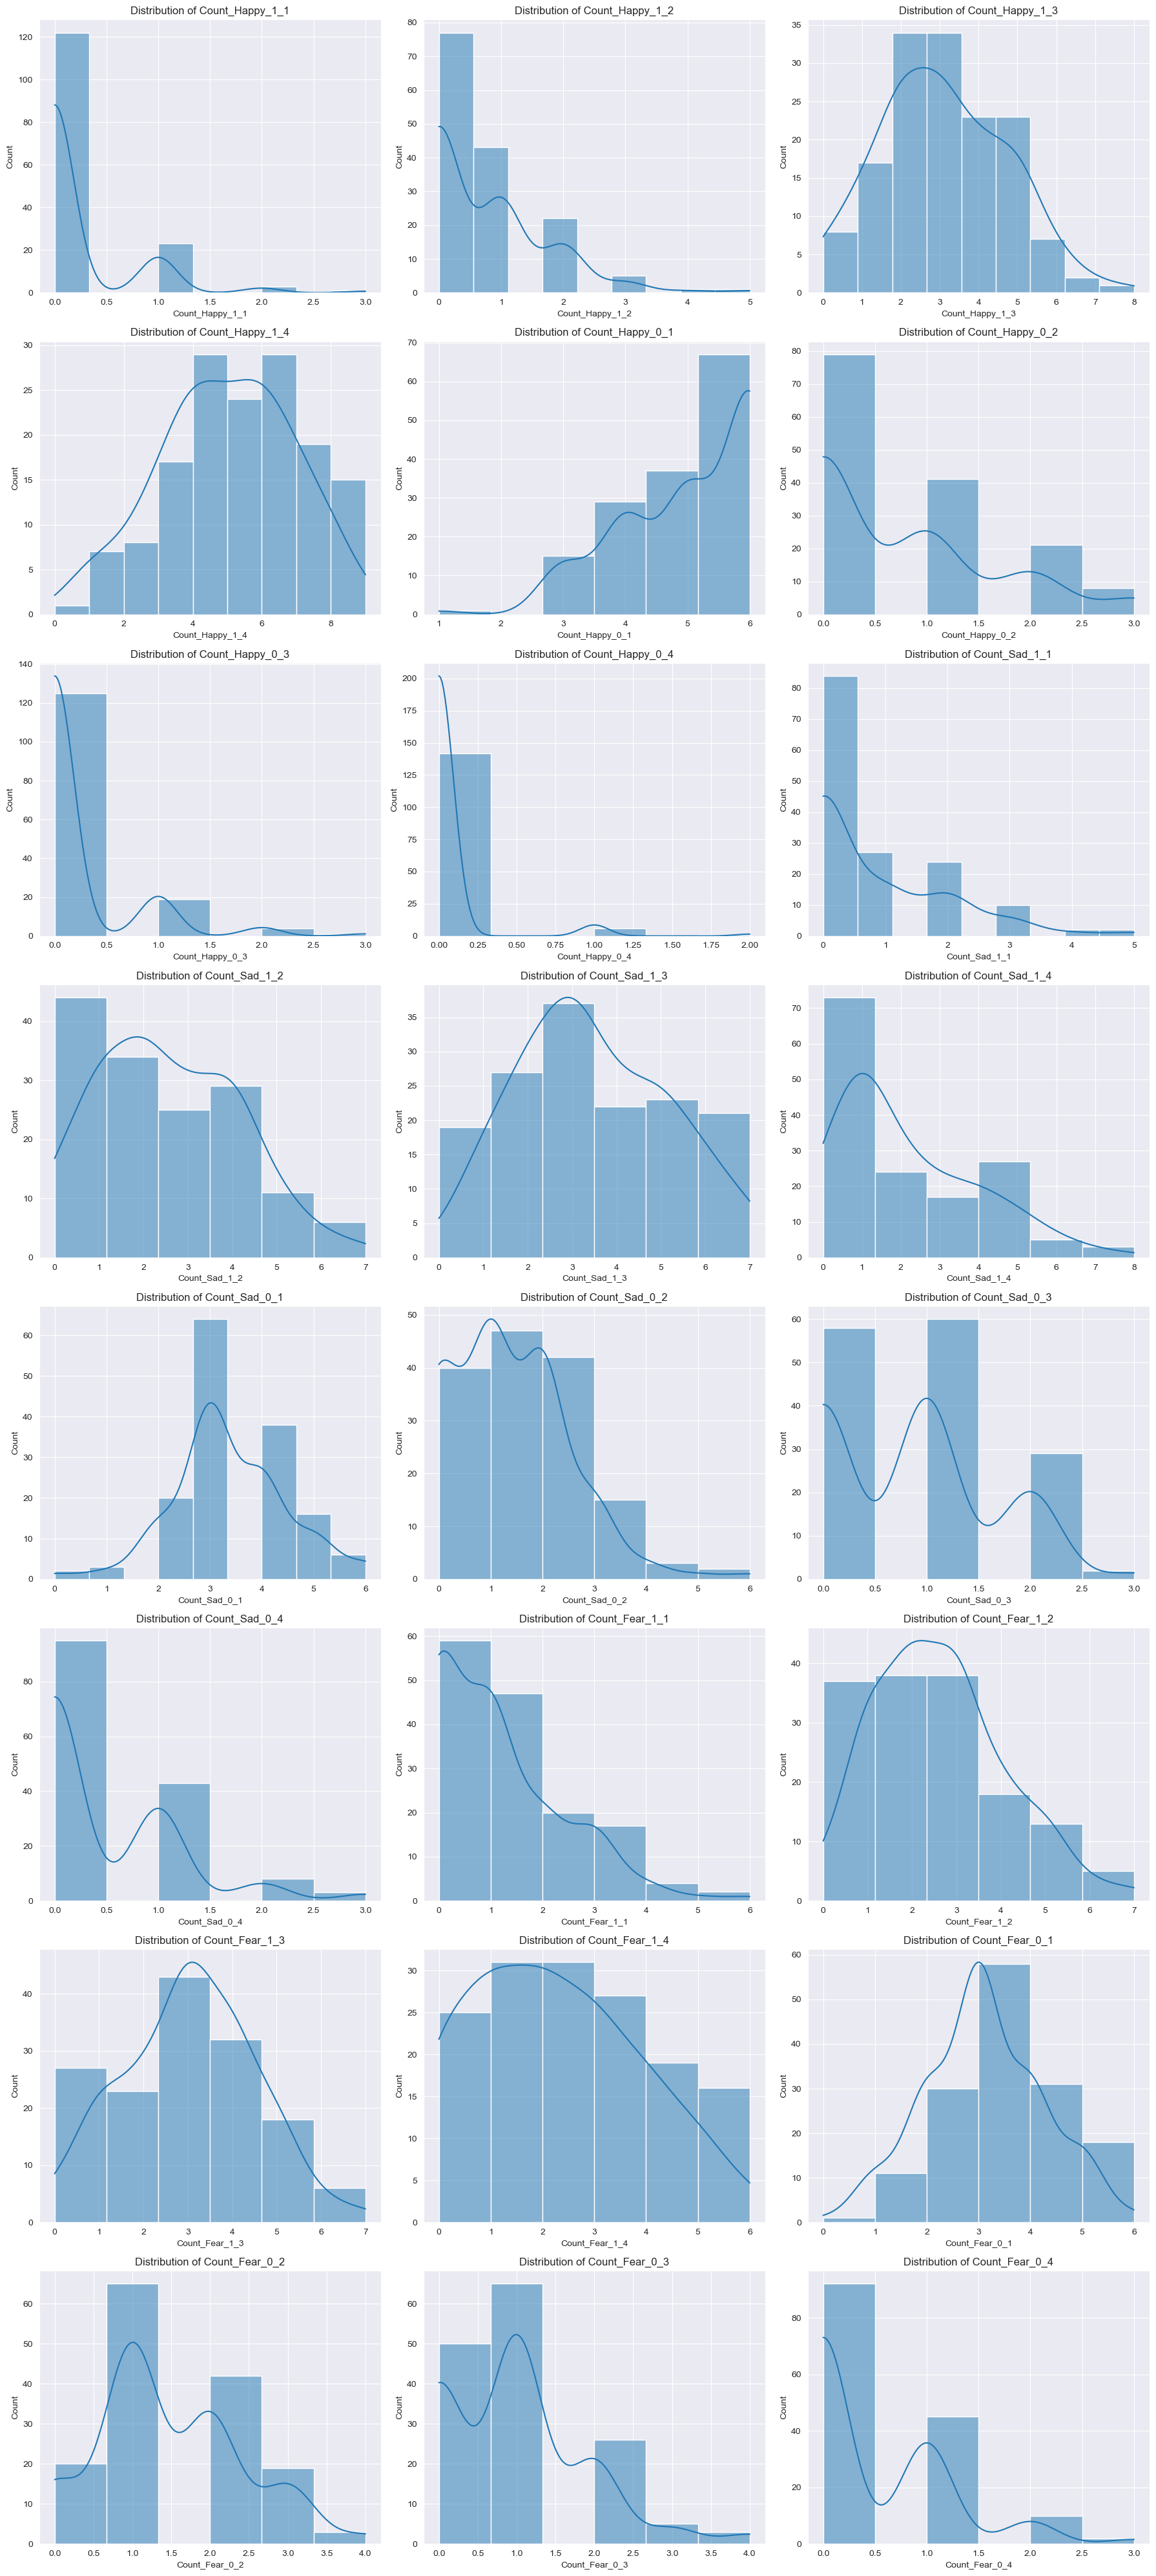

In [5]:
warnings.filterwarnings('ignore', category=FutureWarning)

# Determinamos cuántos subgráficos necesitamos
n_cols = 3  # Número de subgráficos por fila
n_rows = int(np.ceil(len(data.columns) / n_cols))-1

# Configuramos la figura
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 5 * n_rows))

# Iteramos sobre cada columna y generamos el gráfico correspondiente
for i, col in enumerate(data.drop("Subject",axis=1).columns):
    ax = axes[i // n_cols, i % n_cols]

    if col[12] == "1":
        sns.histplot(data[col], bins=9, kde=True,ax=ax)
        ax.set_title(f'Distribution of {col}')
    else:
        sns.histplot(data[col], bins=6,kde=True, ax=ax)
        ax.set_title(f'Distribution of {col}')


# Ajustamos el layout y mostramos el gráfico
plt.tight_layout()
plt.show()

#### Correlación de las variables


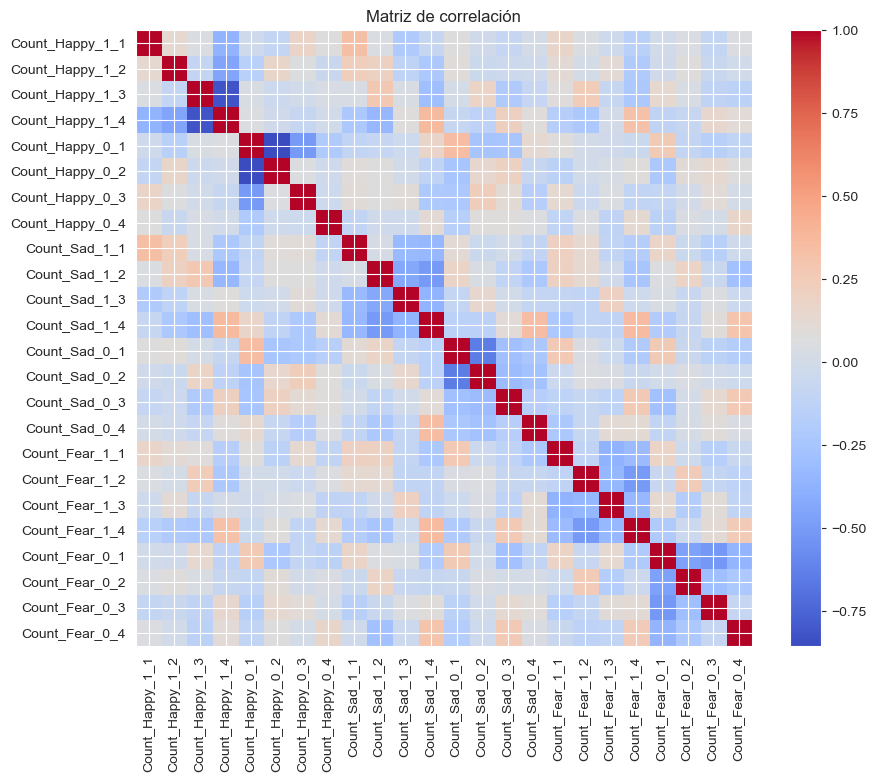

In [6]:
correlation_matrix = data.drop("Subject",axis=1).corr()
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Matriz de correlación')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()


Se puede observar en general correlaciones positivas entre diferentes emociones que mantienen el mismo match y tienen la misma puntuación. Se observa correlación negativa entre las variables de conteo de una misma emoción y mismo match (las matrices 4x4 que se generan alrededor de la diagonal).

## Adding Correlation between Rating & Rating0

In [7]:
pred_data = pd.read_excel("RETOS_BEBRASK_Rating0_Time_Series.xlsx")
like_data = pd.read_excel("RETOS_BEBRASK_Rating_Time_Series.xlsx")
#### Distribución de las variables

In [8]:
pred_data = pred_data.sort_values(by='Subject ID').reset_index(drop=True)

# Sort the second dataset
like_data = like_data.sort_values(by='Subject ID').reset_index(drop=True)

# Sort the third dataset
data = data.sort_values(by='Subject').reset_index(drop=True)

In [9]:
correlation_coefficients = []

# Iterate over each row pair
for index, row_df1 in pred_data.drop("Subject ID",axis=1).iterrows():
    row_df2 = like_data.drop("Subject ID",axis=1).loc[index]  # Get corresponding row from df2
    correlation = row_df1.corr(row_df2)  # Compute correlation
    correlation_coefficients.append(correlation)

# Convert the list to a pandas Series
correlation_series = pd.Series(correlation_coefficients)

# Print the correlation coefficients
data["Cor_Pred_Like"]= correlation_series

## Adding difference of Rating0 between match and no match (not differentiating emotion)

In [10]:
#data['Dif_Happy'] = pred_data[['Happy_1_0', 'Happy_1_1', 'Happy_1_2', 'Happy_1_3', 'Happy_1_4', 'Happy_1_5', 'Happy_1_6', 'Happy_1_7', 'Happy_1_8']].mean(axis=1)- pred_data[['Happy_0_0', 'Happy_0_1', 'Happy_0_2', 'Happy_0_3', 'Happy_0_4', 'Happy_0_5']].mean(axis=1)
    
#data['Dif_Sad'] = pred_data[['Sad_1_0', 'Sad_1_1', 'Sad_1_2', 'Sad_1_3', 'Sad_1_4', 'Sad_1_5', 'Sad_1_6', 'Sad_1_7', 'Sad_1_8']].mean(axis=1) - pred_data[['Sad_0_0', 'Sad_0_1', 'Sad_0_2', 'Sad_0_3', 'Sad_0_4', 'Sad_0_5']].mean(axis=1)
    
#data['Dif_Fear'] = pred_data[['Fear_1_0', 'Fear_1_1', 'Fear_1_2', 'Fear_1_3', 'Fear_1_4', 'Fear_1_5', 'Fear_1_6', 'Fear_1_7', 'Fear_1_8']].mean(axis=1)- pred_data[['Fear_0_0', 'Fear_0_1', 'Fear_0_2', 'Fear_0_3', 'Fear_0_4', 'Fear_0_5']].mean(axis=1)

total_dif = pred_data[['Happy_1_0', 'Happy_1_1', 'Happy_1_2', 'Happy_1_3', 'Happy_1_4', 'Happy_1_5', 'Happy_1_6', 'Happy_1_7', 'Happy_1_8','Sad_1_0', 'Sad_1_1', 'Sad_1_2', 'Sad_1_3', 'Sad_1_4', 'Sad_1_5', 'Sad_1_6', 'Sad_1_7', 'Sad_1_8','Fear_1_0', 'Fear_1_1', 'Fear_1_2', 'Fear_1_3', 'Fear_1_4', 'Fear_1_5', 'Fear_1_6', 'Fear_1_7', 'Fear_1_8']].mean(axis=1) - pred_data[['Happy_0_0', 'Happy_0_1', 'Happy_0_2', 'Happy_0_3', 'Happy_0_4', 'Happy_0_5','Sad_0_1', 'Sad_0_2', 'Sad_0_3', 'Sad_0_4', 'Sad_0_5','Fear_0_0', 'Fear_0_1', 'Fear_0_2', 'Fear_0_3', 'Fear_0_4', 'Fear_0_5']].mean(axis=1)


## Baseline Avg Rating0, Difference & Correlation 

In [11]:
mean_subject = pred_data.drop("Subject ID",axis=1).mean(axis=1)
baseline = pd.concat([pred_data["Subject ID"], mean_subject, total_dif,data["Cor_Pred_Like"]],axis=1)

In [12]:
baseline.columns = ['Subject ID','Mean_Rating0','Dif_Match', 'Cor_Pred_Like']

In [13]:
#Normalization
scaler = StandardScaler()
scaled_data = scaler.fit_transform(baseline.drop("Subject ID",axis=1))

#### Hierarchical

In [14]:
silhouette = []
db = []
for n in range(2,20):
    clustering = AgglomerativeClustering(n_clusters=n,linkage="complete").fit(scaled_data)
    silhouette.append(silhouette_score(scaled_data, clustering.labels_))
    db.append(davies_bouldin_score(scaled_data, clustering.labels_))
    

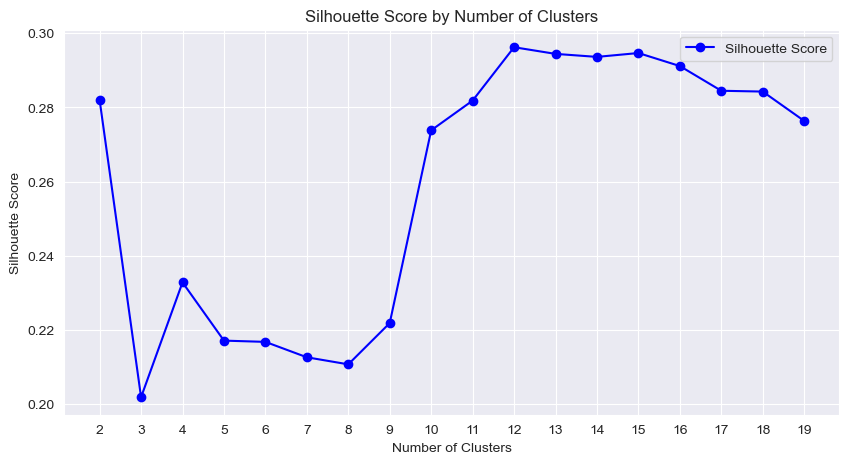

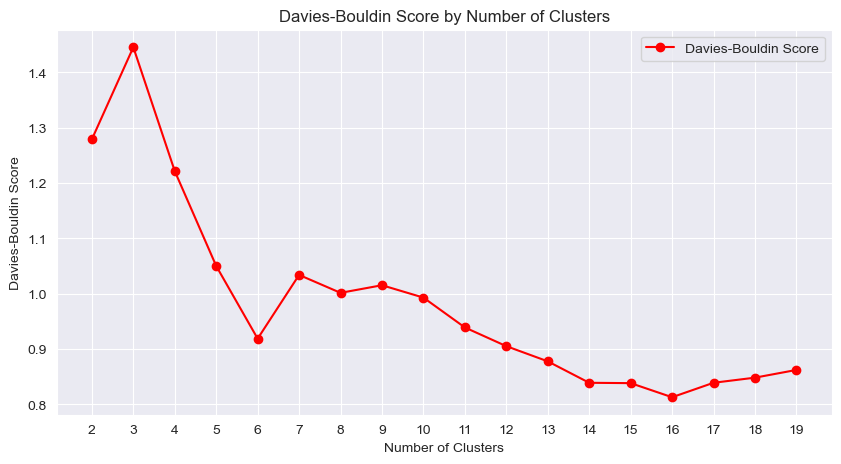

In [15]:
# Assuming silhouette and db lists are filled with scores for cluster numbers from 2 to 11
cluster_range = range(2, 20)

# Plotting the silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette, marker='o', linestyle='-', color='blue', label='Silhouette Score')
plt.title('Silhouette Score by Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.xticks(cluster_range)
plt.show()

# Plotting the Davies-Bouldin scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, db, marker='o', linestyle='-', color='red', label='Davies-Bouldin Score')
plt.title('Davies-Bouldin Score by Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.legend()
plt.grid(True)
plt.xticks(cluster_range)
plt.show()
#### OPTICS Clustering

###### Create excel

In [16]:
for n in range(2,6):
    clustering = AgglomerativeClustering(n_clusters=n,linkage="complete").fit(scaled_data)
    export_df = baseline.copy()
    export_df["clusters"]  = clustering.labels_
    export_df = export_df[["Subject ID","clusters"]]
    export_df.columns = ["EPRIME_CODE","clusters"]
    name_excel =  f'Clusters_Raw/Hierarchical_Clusters/raw_predictive_processing_hierarchical_{n}_clusters.xlsx'
    export_df.to_excel(name_excel, index=False)

###### Look Metrics


In [17]:
clustering = AgglomerativeClustering(n_clusters=5,linkage="complete").fit(scaled_data)
copy_baseline = baseline.copy()
copy_baseline["clusters"] = clustering.labels_
cluster_hierarchical = create_metrics_cluster_df(copy_baseline[["Subject ID","clusters"]], scales)
cluster_hierarchical


,PA_mean,NA._mean,ERQ_CR_mean,ERQ_ES_mean,UPPSP_NU_mean,UPPSP_PU_mean,UPPSP_SS_mean,UPPSP_PMD_mean,UPPSP_PSV_mean,BIS_mean,...,ZKPQ_ACT_mean,ZKPQ_SY_mean,ZKPQ_IMPSS_mean,ZKPQ_AGG_HOST_mean,ZKPQ_INFREQ_mean,SPQ_mean,SPQ_IR_mean,MSSB_POS_mean,MSSB_NEG_mean,MSSB_DES_mean
0,32.08,20.74,4.52,3.14,9.69,10.10,10.36,8.03,7.72,21.38,...,8.14,7.52,9.34,7.10,1.60,2.28,2.83,1.93,2.34,2.76
1,34.54,19.43,5.24,3.04,8.32,9.97,11.59,7.19,6.46,21.32,...,8.19,8.14,9.43,6.48,1.29,2.17,2.55,1.76,1.97,2.03
2,33.90,20.22,5.00,3.09,8.68,9.67,10.80,7.03,7.03,21.78,...,8.39,5.87,8.44,6.59,1.59,2.23,2.67,2.04,1.71,1.94
3,27.44,21.33,4.57,2.08,9.89,10.11,10.33,8.44,7.33,23.89,...,7.14,7.86,8.00,6.86,2.00,2.50,2.67,1.83,1.17,3.33
4,35.75,21.50,4.38,3.25,7.00,8.50,10.75,6.50,5.50,19.25,...,9.50,6.00,8.50,5.50,1.50,1.50,2.00,2.00,1.75,3.25


In [18]:
np.unique(copy_baseline["clusters"],return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64), array([39, 37, 60,  9,  4], dtype=int64))

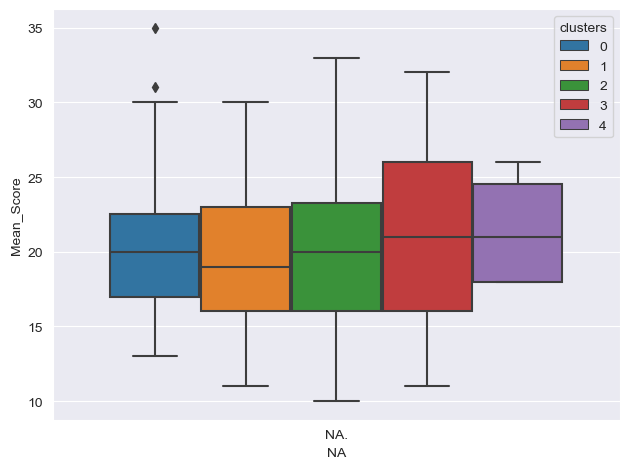

In [19]:
new_data = pd.merge(scales.copy(),copy_baseline[["Subject ID", "clusters"]].copy(), right_on='Subject ID', left_on='EPRIME_CODE')
new_data.drop("Subject ID",axis=1,inplace=True)
numeric_columns = new_data.select_dtypes(include=[np.number]).columns
columns_to_select = ['EPRIME_CODE'] + list(numeric_columns) + ["ERQ_ES"] + ["UPPSP_PMD"]

# Selecting all numeric columns along with "Subject"
filtered_df = new_data[columns_to_select]
cols_to_drop = filtered_df.columns[filtered_df.isnull().sum() > 50]
filtered_df = filtered_df.drop(columns=cols_to_drop).copy()
filtered_df.drop("Age", axis=1, inplace=True)
prove = pd.melt(filtered_df, id_vars=['clusters'], value_vars=['NA.'], var_name = 'NA',value_name='Mean_Score')
sns.boxplot(x='NA', y='Mean_Score', hue='clusters', data=prove)
plt.tight_layout()
plt.show()


In [20]:
PANAS = ["PA","NA."]
ERQ = ["ERQ_CR","ERQ_ES"]
UPPSP = ["UPPSP_NU","UPPSP_PU","UPPSP_SS","UPPSP_PMD","UPPSP_PSV"]
BIS_BAS = ["BIS","BAS_D","BAS_RR","BAS_FS"]
TEPS = ["TEPS_AF","TEPS_CF"]
SHS = ["SHS"]
FS = ["FS"]
LOTR = ["LOT_R"]
RRQ = ["RRQ_Rum","RRQ_Ref"]
ASI3 = ["ASI_P","ASI_C","ASI_S"]
SPQ = ["SPQ","SPQ_IR"]
MSSB = ["MSSB_POS","MSSB_NEG","MSSB_DES"]

list_metrics = [PANAS,ERQ,UPPSP,BIS_BAS,TEPS,SHS,FS,LOTR,RRQ,ASI3,SPQ,MSSB]

In [21]:
from docx import Document
from docx.shared import Inches
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

for n in range(2,7):
    
    name_output = f"raw_hierarchical_{n}_clusters.docx"
    
    clustering = AgglomerativeClustering(n_clusters=n,linkage="complete").fit(scaled_data)
    copy_baseline = baseline.copy()
    copy_baseline["clusters"] = clustering.labels_
    
    new_data = pd.merge(scales.copy(),copy_baseline[["Subject ID", "clusters"]].copy(), right_on='Subject ID', left_on='EPRIME_CODE')
    new_data.drop("Subject ID",axis=1,inplace=True)
    numeric_columns = new_data.select_dtypes(include=[np.number]).columns
    columns_to_select = ['EPRIME_CODE'] + list(numeric_columns) + ["ERQ_ES"] + ["UPPSP_PMD"]
    
    # Selecting all numeric columns along with "Subject"
    filtered_df = new_data[columns_to_select]
    cols_to_drop = filtered_df.columns[filtered_df.isnull().sum() > 50]
    filtered_df = filtered_df.drop(columns=cols_to_drop).copy()
    filtered_df.drop("Age", axis=1, inplace=True)
    
    
    doc = Document()
    size_clust = np.unique(copy_baseline["clusters"], return_counts=True)[1]
    
    for idx, group in enumerate(list_metrics):
        # Add group name to the document
        doc.add_paragraph(f"Group {idx + 1}: {', '.join(group)}")
    
        # Select columns belonging to the group
        columns_to_plot = ['clusters'] + group
        group_df = filtered_df[columns_to_plot]
    
        # Melt the dataframe
        melted_df = pd.melt(group_df, id_vars=['clusters'], value_vars=group,
                            var_name='Variable', value_name='Mean_Score')
        
        num_cols = len(group)
        for i, variable in enumerate(group):
            # Create a new figure for each variable
            plt.figure(figsize=(8, 6))
            ax = plt.gca()
    
            # Plot boxplot for the current variable
            sns.boxplot(x='clusters', y='Mean_Score', data=melted_df[melted_df['Variable'] == variable], ax=ax)
            ax.set_title(f'Boxplot for {variable}')
            ax.set_xlabel('Clusters')
            ax.set_ylabel('Mean Score')
            ax.grid(True)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
            # Calculate mean
            means = melted_df[melted_df['Variable'] == variable].groupby('clusters')['Mean_Score'].mean()
            stats = melted_df[melted_df['Variable'] == variable].groupby('clusters')['Mean_Score'].agg(['size', 'mean', 'std'])
            
            # Add text annotation for mean below the boxplot
            for cluster, mean in enumerate(means):
                ax.text(cluster, mean, f'{mean:.2f}', ha='center', va='top', color='red')
    
            plt.tight_layout()
            plot_filename = f'plot_{idx}_{i}.png'  # Generate unique filename
            plt.savefig(plot_filename)
            plt.close()
    
            # Generate table for statistics
            stats.reset_index(inplace=True)
            stats["clusters"] = stats["clusters"]
            stats["mean"] = stats["mean"].round(2)
            stats["std"] = stats["std"].round(2)
            stats['SE of Cluster'] = (stats['std'] / np.sqrt(stats['size'])).round(2)
            stats['size'] = size_clust
    
            stats.columns = ["Number of Cluster", "Size of Cluster", "Mean of Cluster", "Standard Deviation of Cluster",
                             "SE of Cluster"]
    
            plt.figure(figsize=(8, 2))
            table = plt.table(cellText=stats.drop("Standard Deviation of Cluster", axis=1).values,
                              colLabels=stats.drop("Standard Deviation of Cluster", axis=1).columns,
                              cellLoc='center',
                              loc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(1, 1)
            table.auto_set_column_width([i for i in range(len(stats.columns))])
            plt.axis('off')
            plt.title(f'Statistics for {variable}')
            table_filename = f'table_{idx}_{i}.png'  # Generate unique filename
            plt.savefig(table_filename)
            plt.close()
            
                # Add plot and table to the Word document in the same row
            table_cell = doc.add_table(rows=1, cols=2)
            table_row = table_cell.rows[0]
            cell1 = table_row.cells[0]
            cell2 = table_row.cells[1]
            
            cell1.paragraphs[0].add_run().add_picture(plot_filename, width=Inches(3))  # Adjust width as needed
            cell2.paragraphs[0].add_run().add_picture(table_filename, width=Inches(3))  # Adjust width as 
    doc.save(name_output)



In [22]:
create_mean_tasks(pred_data,copy_baseline[["Subject ID","clusters"]])


,Cluster,Happy_0,Happy_1,Sad_0,Sad_1,Fear_0,Fear_1
0,1.0,1.126126,3.624625,1.752252,3.099099,1.702703,2.996997
1,2.0,1.267544,3.292398,1.719298,2.535088,1.872807,2.555556
2,0.0,1.211111,3.485185,1.766667,2.820370,1.838889,2.761111
3,4.0,1.750000,2.638889,1.958333,2.138889,2.250000,2.194444
4,3.0,1.018519,3.049383,1.222222,2.246914,1.388889,2.049383
5,5.0,2.166667,3.444444,2.500000,3.666667,2.833333,3.222222


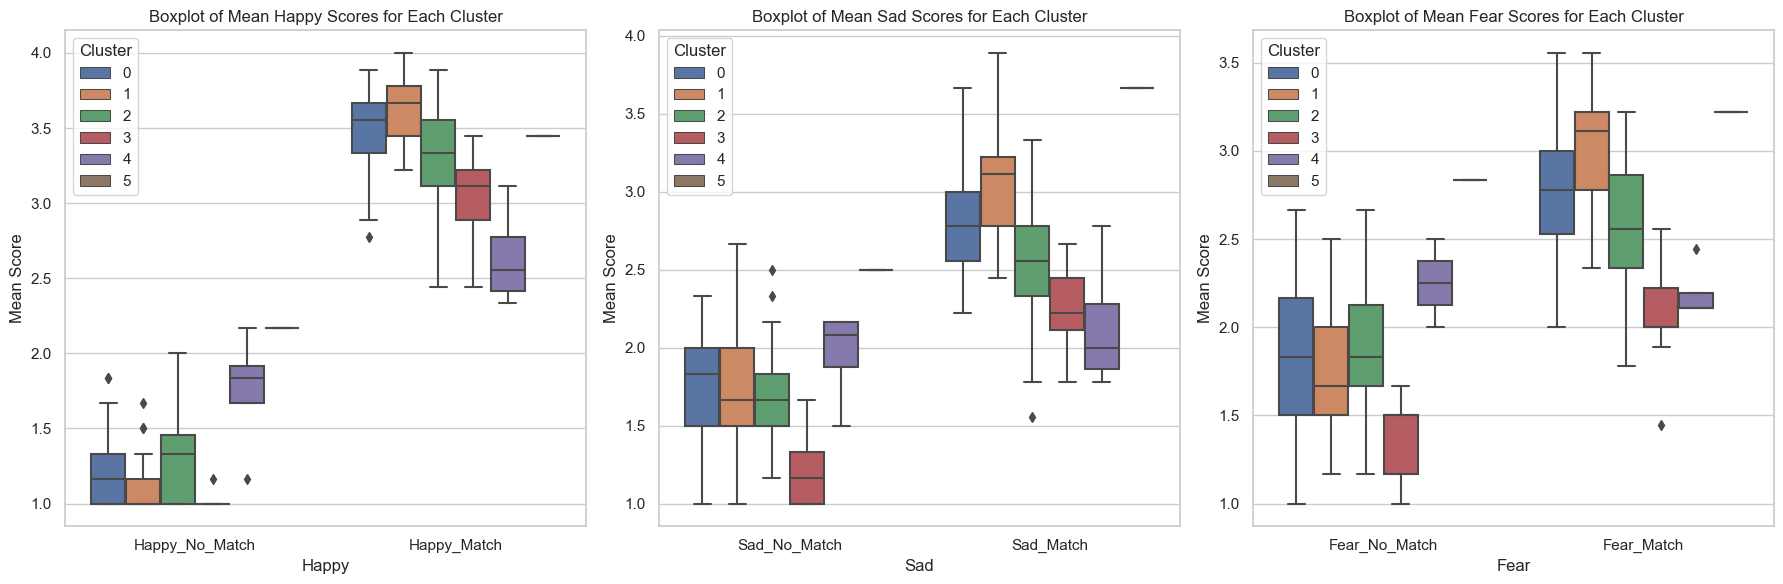

In [23]:
create_boxplots(pred_data,copy_baseline[["Subject ID","clusters"]])

#### OPTICS

In [24]:
silhouette = []
db = []
for n in range(4, 10):
    clustering = OPTICS(min_samples=n, metric="euclidean", algorithm="auto").fit(scaled_data)
    #print(n,np.unique(clustering.labels_))
    copy_df = scaled_data.copy()
    copy_df = pd.DataFrame(copy_df)

    copy_df["clusters"] = clustering.labels_.copy()
    copy_df = copy_df[copy_df["clusters"] != -1]
    silhouette.append(silhouette_score(copy_df.drop("clusters",axis=1), copy_df["clusters"]))
    db.append(davies_bouldin_score(copy_df.drop("clusters",axis=1), copy_df["clusters"]))



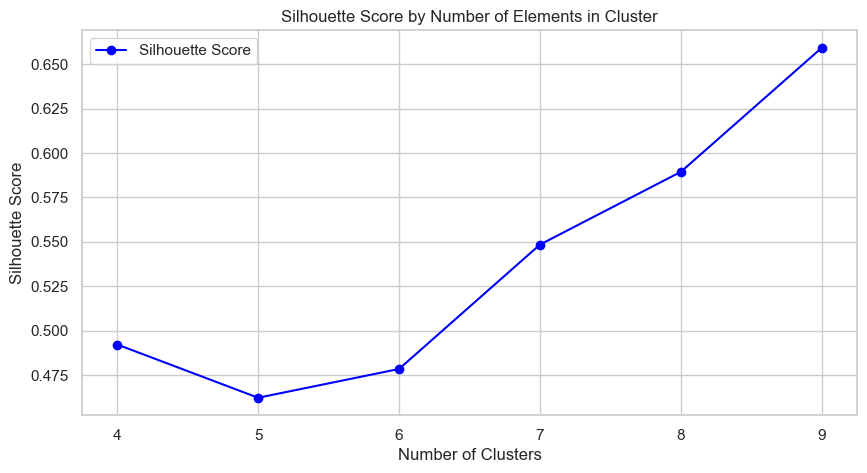

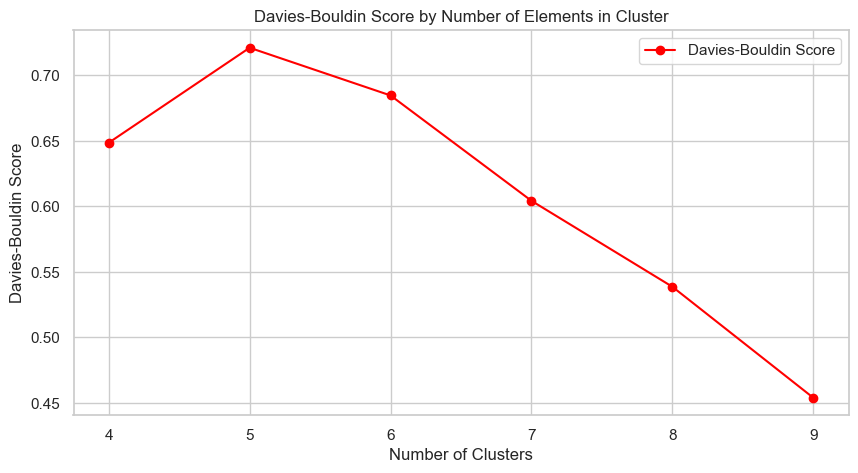

In [25]:
# Assuming silhouette and db lists are filled with scores for cluster numbers from 2 to 11
cluster_range = range(4, 10)

# Plotting the silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette, marker='o', linestyle='-', color='blue', label='Silhouette Score')
plt.title('Silhouette Score by Number of Elements in Cluster')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.xticks(cluster_range)
plt.show()

# Plotting the Davies-Bouldin scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, db, marker='o', linestyle='-', color='red', label='Davies-Bouldin Score')
plt.title('Davies-Bouldin Score by Number of Elements in Cluster')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.legend()
plt.grid(True)
plt.xticks(cluster_range)
plt.show()


###### Create excel


In [26]:
for n in range(4, 10):
    clustering = OPTICS(min_samples=n, metric="euclidean", algorithm="auto").fit(scaled_data)
    export_df = baseline.copy()
    export_df["clusters"] = clustering.labels_
    export_df = export_df[["Subject ID", "clusters"]]
    export_df.columns = ["EPRIME_CODE", "clusters"]
    name_excel = f'Clusters_Raw/OPTICS_Clusters/raw_predictive_processing_optics_{n}_subjects_for_cluster.xlsx'
    export_df.to_excel(name_excel, index=False)


In [27]:
sns.set(style="whitegrid")

for n in range(4,8):

name_output = f"raw_OPTICS_{n}_per_clusters.docx"

clustering = OPTICS(min_samples=n, metric="euclidean", algorithm="auto").fit(scaled_data)
copy_baseline = baseline.copy()
copy_baseline["clusters"] = clustering.labels_


new_data = pd.merge(scales.copy(),copy_baseline[["Subject ID", "clusters"]].copy(), right_on='Subject ID', left_on='EPRIME_CODE')
new_data.drop("Subject ID",axis=1,inplace=True)
numeric_columns = new_data.select_dtypes(include=[np.number]).columns
columns_to_select = ['EPRIME_CODE'] + list(numeric_columns) + ["ERQ_ES"] + ["UPPSP_PMD"]
new_data = new_data[new_data["clusters"] != -1]

# Selecting all numeric columns along with "Subject"
filtered_df = new_data[columns_to_select]
cols_to_drop = filtered_df.columns[filtered_df.isnull().sum() > 50]
filtered_df = filtered_df.drop(columns=cols_to_drop).copy()
filtered_df.drop("Age", axis=1, inplace=True)


doc = Document()
size_clust = np.unique(new_data["clusters"], return_counts=True)[1]

for idx, group in enumerate(list_metrics):
    # Add group name to the document
    doc.add_paragraph(f"Group {idx + 1}: {', '.join(group)}")

    # Select columns belonging to the group
    columns_to_plot = ['clusters'] + group
    group_df = filtered_df[columns_to_plot]

    # Melt the dataframe
    melted_df = pd.melt(group_df, id_vars=['clusters'], value_vars=group,
                        var_name='Variable', value_name='Mean_Score')
    
    num_cols = len(group)
    for i, variable in enumerate(group):
        # Create a new figure for each variable
        plt.figure(figsize=(8, 6))
        ax = plt.gca()

        # Plot boxplot for the current variable
        sns.boxplot(x='clusters', y='Mean_Score', data=melted_df[melted_df['Variable'] == variable], ax=ax)
        ax.set_title(f'Boxplot for {variable}')
        ax.set_xlabel('Clusters')
        ax.set_ylabel('Mean Score')
        ax.grid(True)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

        # Calculate mean
        means = melted_df[melted_df['Variable'] == variable].groupby('clusters')['Mean_Score'].mean()
        stats = melted_df[melted_df['Variable'] == variable].groupby('clusters')['Mean_Score'].agg(['size', 'mean', 'std'])
        
        # Add text annotation for mean below the boxplot
        for cluster, mean in enumerate(means):
            ax.text(cluster, mean, f'{mean:.2f}', ha='center', va='top', color='red')

        plt.tight_layout()
        plot_filename = f'plot_{idx}_{i}.png'  # Generate unique filename
        plt.savefig(plot_filename)
        plt.close()

        # Generate table for statistics
        stats.reset_index(inplace=True)
        stats["clusters"] = stats["clusters"]
        stats["mean"] = stats["mean"].round(2)
        stats["std"] = stats["std"].round(2)
        stats['SE of Cluster'] = (stats['std'] / np.sqrt(stats['size'])).round(2)
        stats['size'] = size_clust

        stats.columns = ["Number of Cluster", "Size of Cluster", "Mean of Cluster", "Standard Deviation of Cluster",
                         "SE of Cluster"]

        plt.figure(figsize=(8, 2))
        table = plt.table(cellText=stats.drop("Standard Deviation of Cluster", axis=1).values,
                          colLabels=stats.drop("Standard Deviation of Cluster", axis=1).columns,
                          cellLoc='center',
                          loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1)
        table.auto_set_column_width([i for i in range(len(stats.columns))])
        plt.axis('off')
        plt.title(f'Statistics for {variable}')
        table_filename = f'table_{idx}_{i}.png'  # Generate unique filename
        plt.savefig(table_filename)
        plt.close()
        
            # Add plot and table to the Word document in the same row
        table_cell = doc.add_table(rows=1, cols=2)
        table_row = table_cell.rows[0]
        cell1 = table_row.cells[0]
        cell2 = table_row.cells[1]
        
        cell1.paragraphs[0].add_run().add_picture(plot_filename, width=Inches(3))  # Adjust width as needed
        cell2.paragraphs[0].add_run().add_picture(table_filename, width=Inches(3))  # Adjust width as 
doc.save(name_output)


###### Look Metrics

In [28]:
#Optics
clustering = OPTICS(min_samples=9, metric="euclidean", algorithm="auto").fit(scaled_data)
copy_baseline["clusters"] = clustering.labels_
cluster_optics_4 = create_metrics_cluster_df(copy_baseline[["Subject ID","clusters"]], scales)
cluster_optics_4


,PA_mean,NA._mean,ERQ_CR_mean,ERQ_ES_mean,UPPSP_NU_mean,UPPSP_PU_mean,UPPSP_SS_mean,UPPSP_PMD_mean,UPPSP_PSV_mean,BIS_mean,...,ZKPQ_ACT_mean,ZKPQ_SY_mean,ZKPQ_IMPSS_mean,ZKPQ_AGG_HOST_mean,ZKPQ_INFREQ_mean,SPQ_mean,SPQ_IR_mean,MSSB_POS_mean,MSSB_NEG_mean,MSSB_DES_mean
-1,33.10,20.38,4.93,3.06,8.69,9.81,10.81,7.35,6.82,21.75,...,8.17,7.24,8.77,6.69,1.47,2.07,2.54,1.69,1.98,2.19
0,35.22,23.78,4.81,3.14,8.22,9.78,11.56,7.78,7.89,21.00,...,11.67,6.00,8.33,4.00,1.33,3.38,3.50,2.88,1.25,2.88
1,33.12,17.88,4.99,3.03,9.50,9.38,10.69,6.62,6.88,20.88,...,7.86,5.43,8.38,6.88,2.50,2.43,2.57,2.50,1.79,2.07
2,33.30,19.60,4.33,2.65,10.70,11.20,11.00,8.90,9.10,22.00,...,7.00,7.80,12.40,8.60,1.50,2.30,3.20,2.50,1.90,2.80


In [29]:
create_mean_tasks(pred_data,copy_baseline[["Subject ID","clusters"]])


,Cluster,Happy_0,Happy_1,Sad_0,Sad_1,Fear_0,Fear_1
0,-1.0,1.214912,3.454191,1.735380,2.833333,1.827485,2.754386
1,0.0,1.259259,3.567901,2.018519,2.987654,1.925926,3.086420
2,1.0,1.187500,3.243056,1.552083,2.500000,1.729167,2.500000
3,2.0,1.200000,3.200000,1.666667,2.277778,1.550000,2.233333


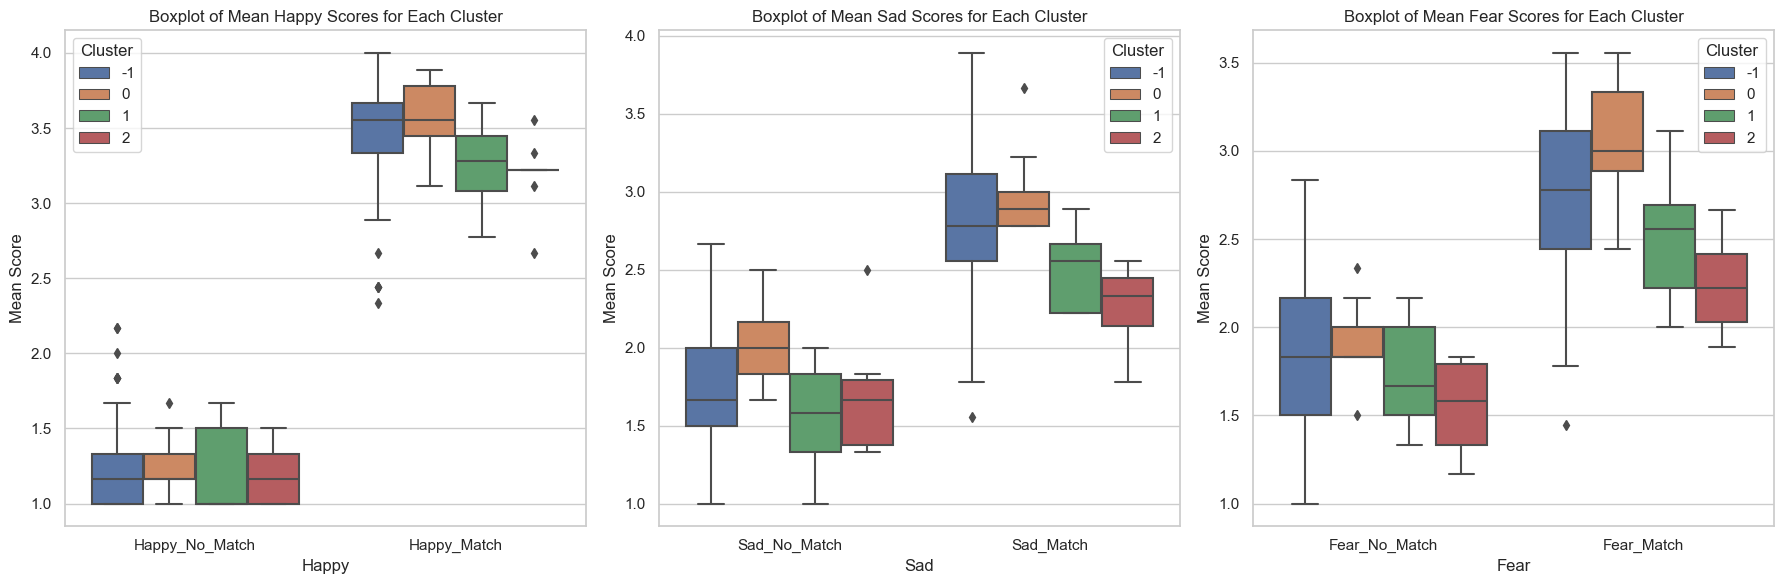

In [30]:
create_boxplots(pred_data,copy_baseline[["Subject ID","clusters"]])


#### KMeans Clustering


In [31]:
from sklearn.cluster import KMeans

silhouette = []
db = []
for n in range(2, 20):
    clustering = KMeans(n_clusters=n, init="k-means++").fit(scaled_data)
    silhouette.append(silhouette_score(scaled_data, clustering.labels_))
    db.append(davies_bouldin_score(scaled_data, clustering.labels_))


C:\Users\manue\anaconda3\envs\CASLabv2\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\manue\anaconda3\envs\CASLabv2\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\manue\anaconda3\envs\CASLabv2\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\manue\anaconda3\envs\CASLabv2\lib\site-packages\sklearn\cluster\_kmeans.py:1436: User

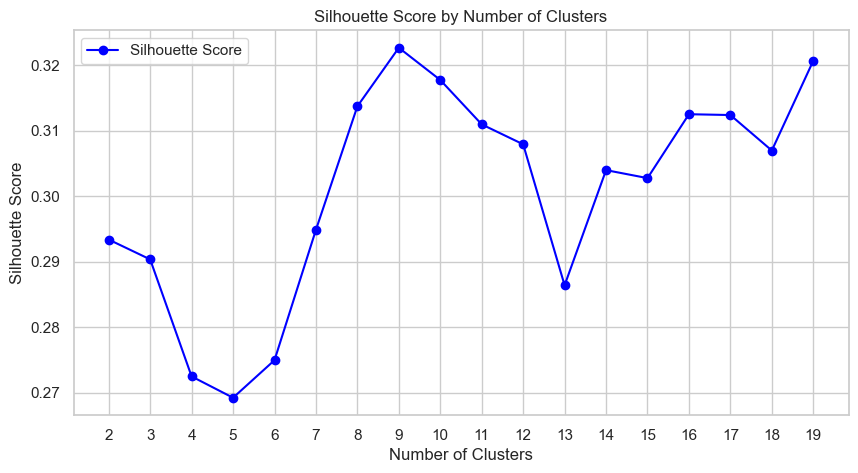

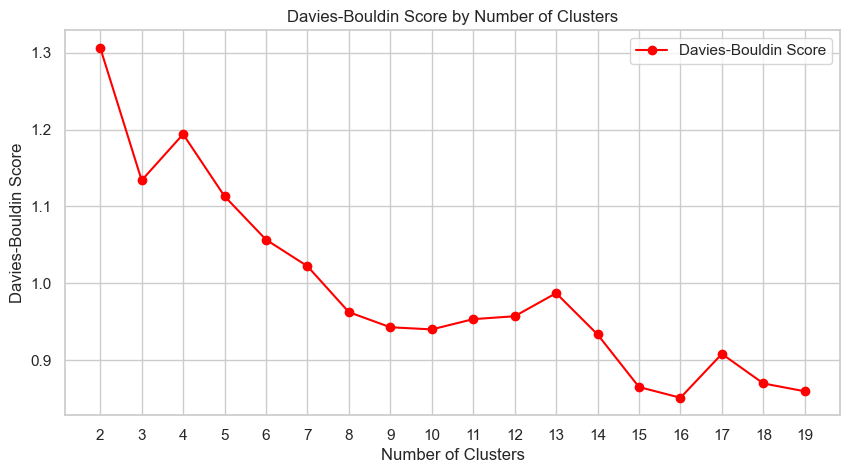

In [32]:
# Assuming silhouette and db lists are filled with scores for cluster numbers from 2 to 11
cluster_range = range(2, 20)

# Plotting the silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette, marker='o', linestyle='-', color='blue', label='Silhouette Score')
plt.title('Silhouette Score by Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.xticks(cluster_range)
plt.show()

# Plotting the Davies-Bouldin scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, db, marker='o', linestyle='-', color='red', label='Davies-Bouldin Score')
plt.title('Davies-Bouldin Score by Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.legend()
plt.grid(True)
plt.xticks(cluster_range)
plt.show()

In [33]:
clustering = KMeans(n_clusters=11,init="k-means++").fit(scaled_data)
copy_baseline["clusters"] = clustering.labels_
cluster_kmeans = create_metrics_cluster_df(copy_baseline[["Subject ID","clusters"]], scales)
cluster_kmeans


C:\Users\manue\anaconda3\envs\CASLabv2\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,PA_mean,NA._mean,ERQ_CR_mean,ERQ_ES_mean,UPPSP_NU_mean,UPPSP_PU_mean,UPPSP_SS_mean,UPPSP_PMD_mean,UPPSP_PSV_mean,BIS_mean,...,ZKPQ_ACT_mean,ZKPQ_SY_mean,ZKPQ_IMPSS_mean,ZKPQ_AGG_HOST_mean,ZKPQ_INFREQ_mean,SPQ_mean,SPQ_IR_mean,MSSB_POS_mean,MSSB_NEG_mean,MSSB_DES_mean
0,26.17,22.33,4.69,2.08,10.17,10.33,10.83,8.50,7.00,24.83,...,6.00,6.00,7.75,7.00,1.75,2.75,3.00,2.00,1.75,4.50
1,35.21,21.71,4.87,2.88,8.14,9.64,11.79,7.50,7.07,20.36,...,8.86,6.43,8.57,7.14,1.14,3.00,3.18,2.45,1.36,2.64
2,32.36,21.29,4.78,3.30,8.64,9.36,10.07,6.29,6.86,23.29,...,7.00,6.29,7.88,6.00,1.38,2.36,2.82,1.91,2.27,2.09
3,30.20,19.87,4.60,3.37,8.87,9.07,9.87,7.67,8.20,21.93,...,7.25,6.42,8.58,6.33,1.50,2.00,2.40,0.70,2.80,2.60
4,32.19,20.94,4.43,3.05,10.06,11.00,10.94,8.44,8.62,21.69,...,8.18,8.18,10.64,7.45,1.67,2.54,3.38,2.54,1.92,2.85
5,34.05,17.76,5.03,2.98,8.76,9.19,10.76,6.90,7.05,21.10,...,8.10,5.90,8.36,6.27,2.09,2.16,2.32,2.53,1.89,1.68
6,36.61,19.11,5.15,3.25,8.56,10.00,11.11,6.67,6.33,21.94,...,7.91,8.27,9.55,6.09,1.45,2.50,2.57,2.21,2.36,3.14
7,35.75,21.50,4.38,3.25,7.00,8.50,10.75,6.50,5.50,19.25,...,9.50,6.00,8.50,5.50,1.50,1.50,2.00,2.00,1.75,3.25
8,34.00,24.80,4.84,2.70,10.00,11.00,9.80,7.40,6.40,22.00,...,10.00,5.67,6.67,9.00,1.67,1.67,3.33,2.00,1.33,3.33
9,34.16,20.32,5.06,2.92,9.47,9.74,10.68,7.83,6.68,20.84,...,9.62,7.73,9.25,7.12,1.56,1.75,2.19,1.50,1.44,1.50


In [34]:
create_mean_tasks(pred_data,copy_baseline[["Subject ID","clusters"]])


,Cluster,Happy_0,Happy_1,Sad_0,Sad_1,Fear_0,Fear_1
0,6.0,1.157407,3.722222,1.898148,3.191358,1.907407,3.104938
1,9.0,1.333333,3.532164,1.982456,2.777778,2.307018,2.853801
2,1.0,1.273810,3.555556,2.000000,3.119048,1.916667,3.095238
3,3.0,1.188889,3.288889,1.600000,2.674074,1.800000,2.607407
4,7.0,1.750000,2.638889,1.958333,2.138889,2.250000,2.194444
5,5.0,1.174603,3.285714,1.595238,2.492063,1.611111,2.486772
6,10.0,1.029412,3.535948,1.450980,2.901961,1.431373,2.751634
7,2.0,1.202381,3.563492,1.702381,2.944444,1.702381,2.801587
8,4.0,1.302083,3.131944,1.625000,2.270833,1.677083,2.236111
9,8.0,1.233333,3.644444,2.100000,3.533333,2.233333,3.311111


C:\Users\manue\anaconda3\envs\CASLabv2\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


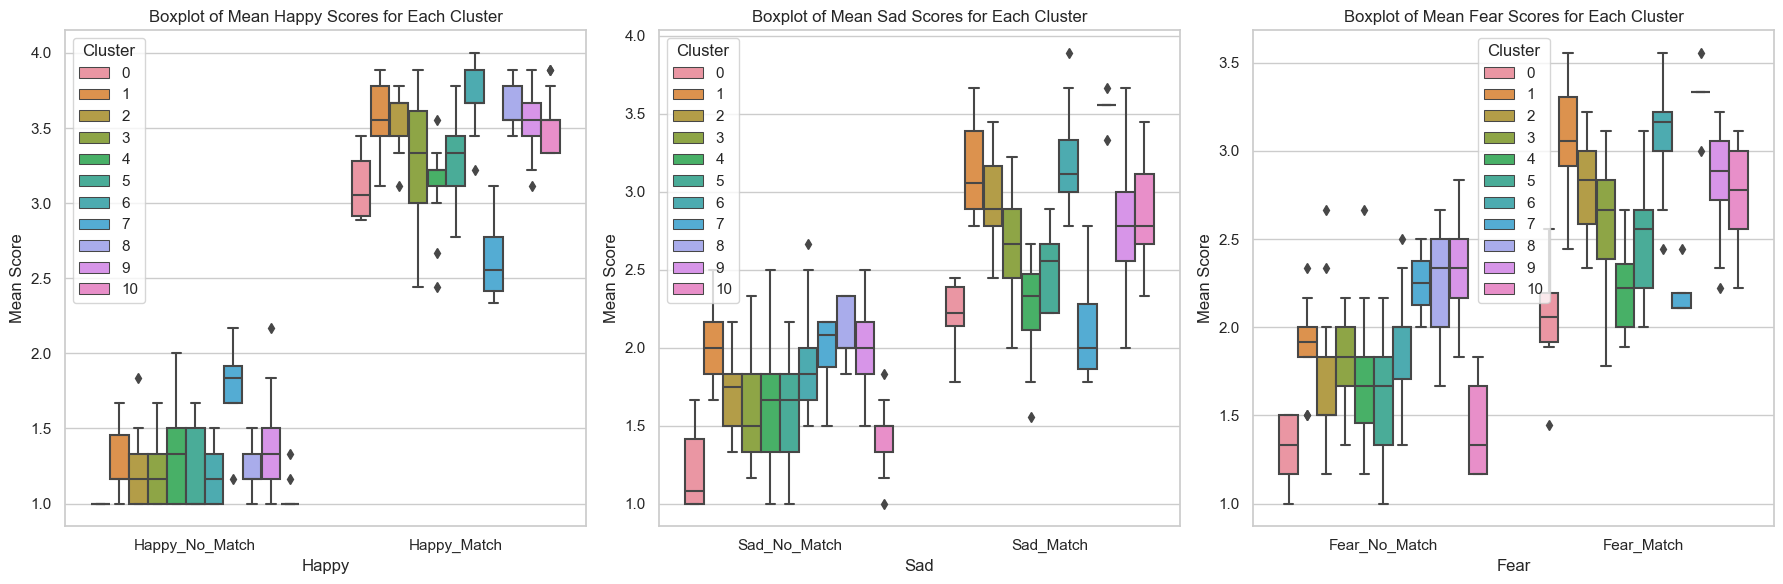

In [35]:
create_boxplots(pred_data,copy_baseline[["Subject ID","clusters"]])


## PLN-PCA Transformation

In [36]:
import pyPLNmodels

In [37]:
import pyPLNmodels
from pyPLNmodels.models import PlnPCAcollection, Pln, ZIPln

In [38]:
tasks = {}
tasks["counts"] = data.drop(["Subject","Cor_Pred_Like"],axis=1).values
tasks["correlation"] = data["Cor_Pred_Like"].values
data["Dif_Match"] = total_dif

#tasks["dif_happy"] = data["Dif_Happy"].values
#tasks["dif_sad"] = data["Dif_Sad"].values
#tasks["dif_fear"] = data["Dif_Fear"].values

zi = ZIPln(endog = tasks["counts"],exog=data[["Cor_Pred_Like","Dif_Match"]])
zi.fit()
print(zi)
transformed_data = zi.transform()
transformed_data = np.array(transformed_data)
df_transformed_data = pd.DataFrame(transformed_data)

Setting the offsets to zero
Fitting a ZIPln model with full covariance model and zero-inflation.
Initialization ...
Initialization finished
Tolerance 0.001 reached in 731 iterations
A multivariate Poisson Lognormal with full covariance model and zero-inflation. 
     Loglike   Dimension    Nb param         BIC         AIC
49984491363.48          24         444-49984490252-49984490919
* Useful properties
    .latent_variables, .model_parameters, .latent_parameters, .optim_parameters
* Useful methods
    .show(), .transform(), .sigma(), .predict(), .pca_projected_latent_variables(), .plot_pca_correlation_circle(), .viz(), .scatter_pca_matrix(), .plot_expected_vs_true()
* Additional properties for ZIPln
    None
* Additional methods for ZIPln
    visualize_latent_prob().


## Distribution of Transformed Data

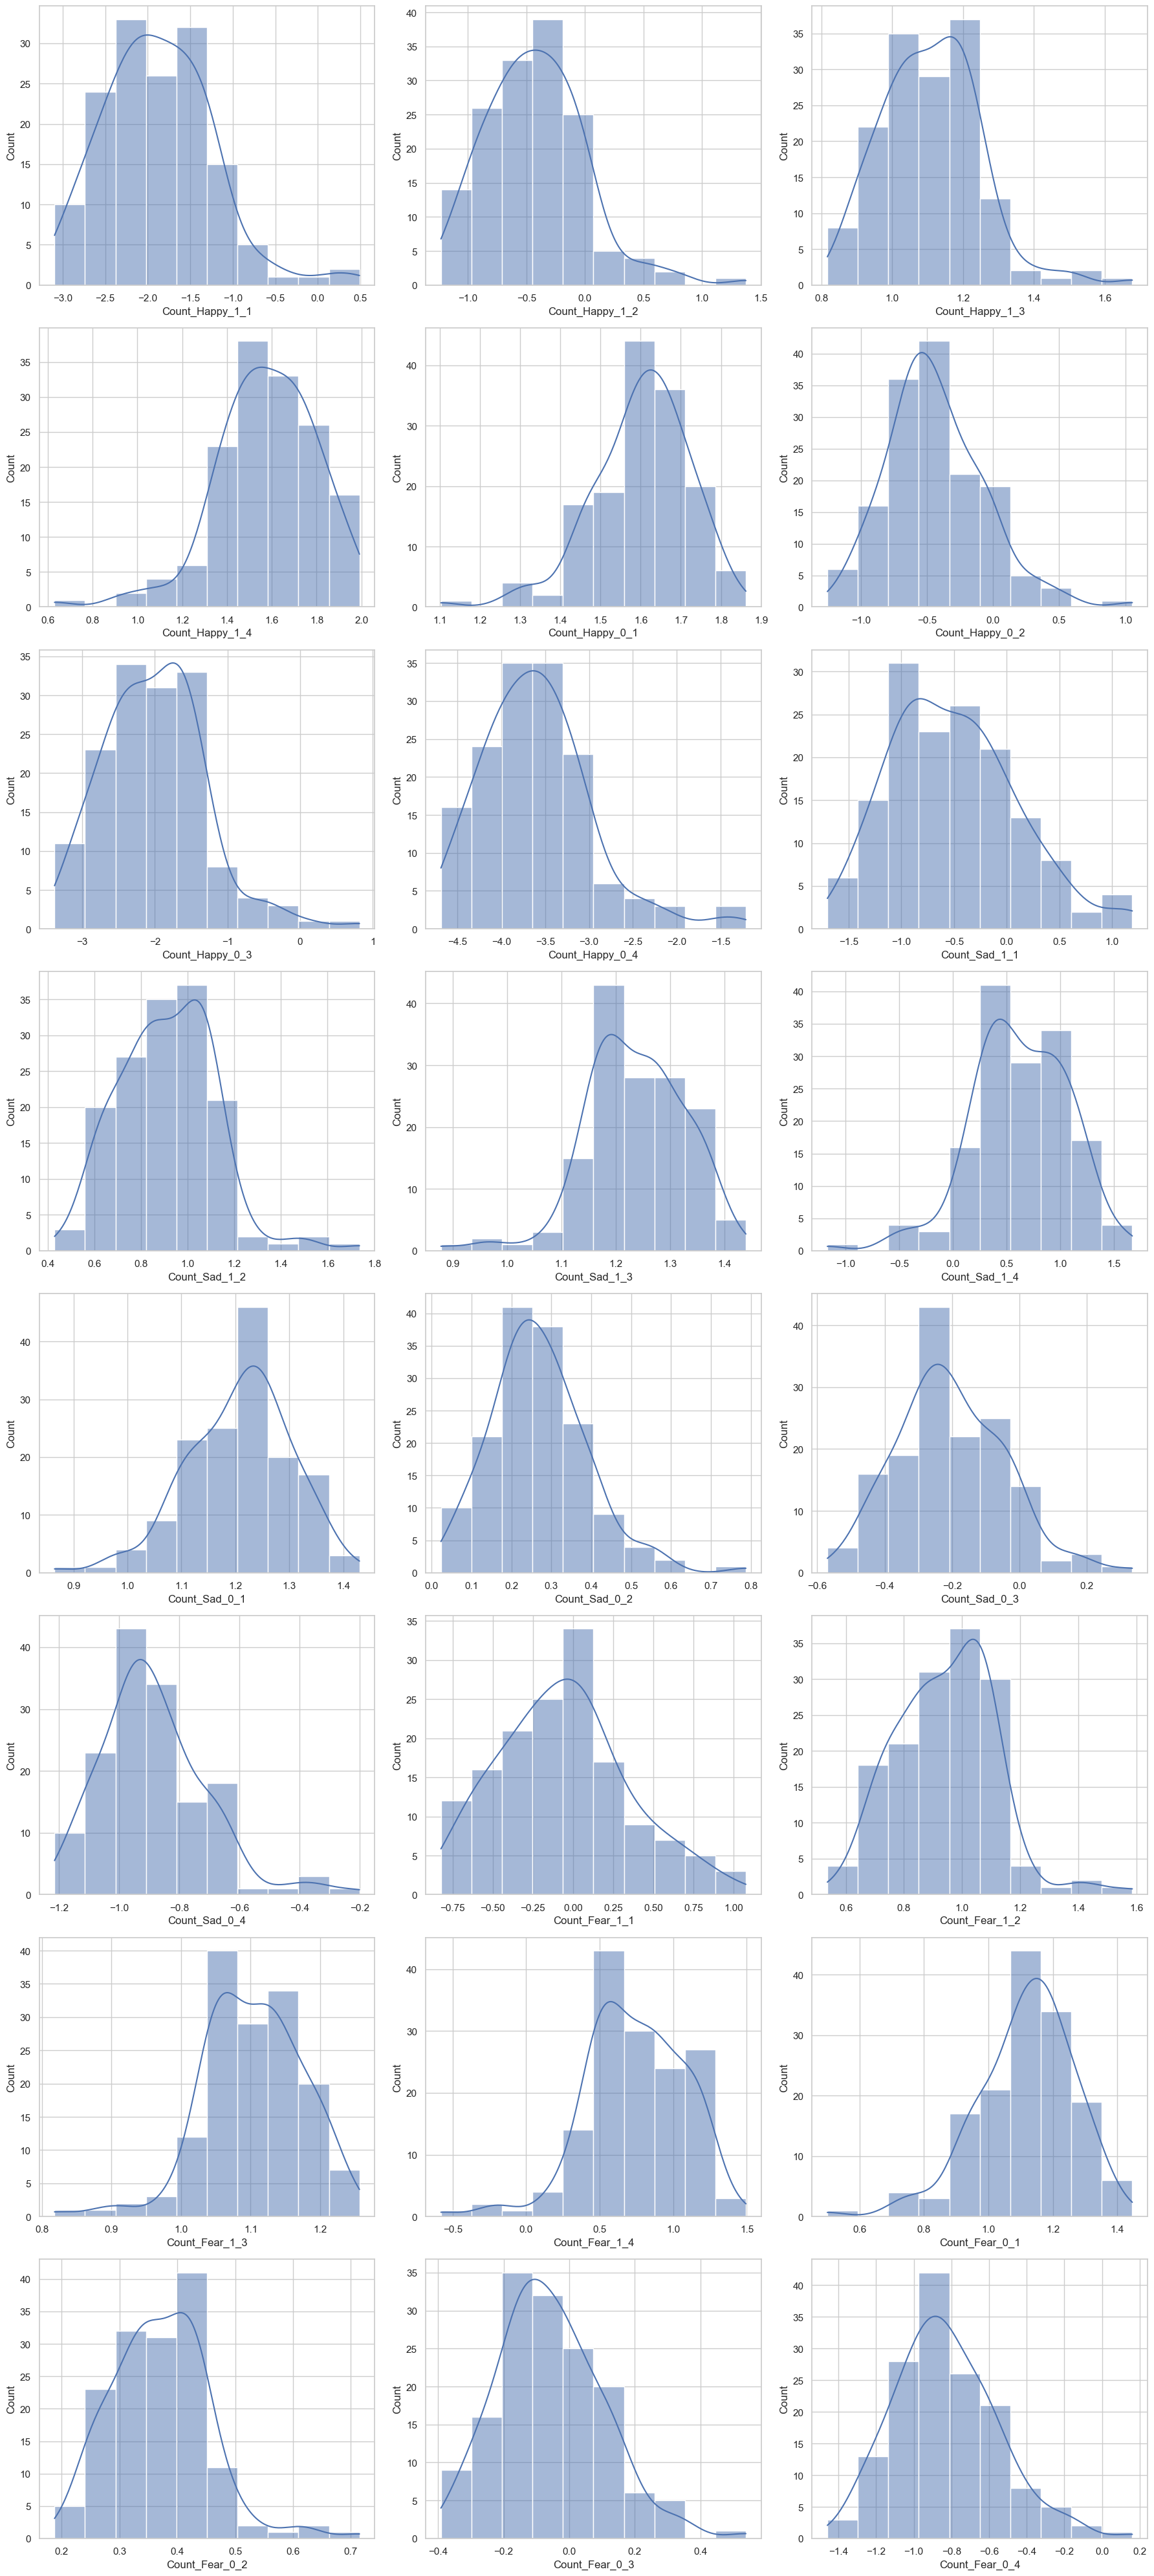

In [39]:
warnings.filterwarnings('ignore', category=FutureWarning)

# Determinamos cuántos subgráficos necesitamos
n_cols = 3  # Número de subgráficos por fila
n_rows = int(np.ceil(len(data.columns) / n_cols)) - 1

# Configuramos la figura
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 5 * n_rows))
df_transformed_data.columns = data.drop(["Subject","Cor_Pred_Like","Dif_Match"],axis=1).columns
# Iteramos sobre cada columna y generamos el gráfico correspondiente
for i, col in enumerate(df_transformed_data.columns):
    ax = axes[i // n_cols, i % n_cols]

    sns.histplot(df_transformed_data[col], bins=10, kde=True, ax=ax)

# Ajustamos el layout y mostramos el gráfico
plt.tight_layout()
plt.show()
#### Correlación de las variables


#### Correlation of Transformed Data


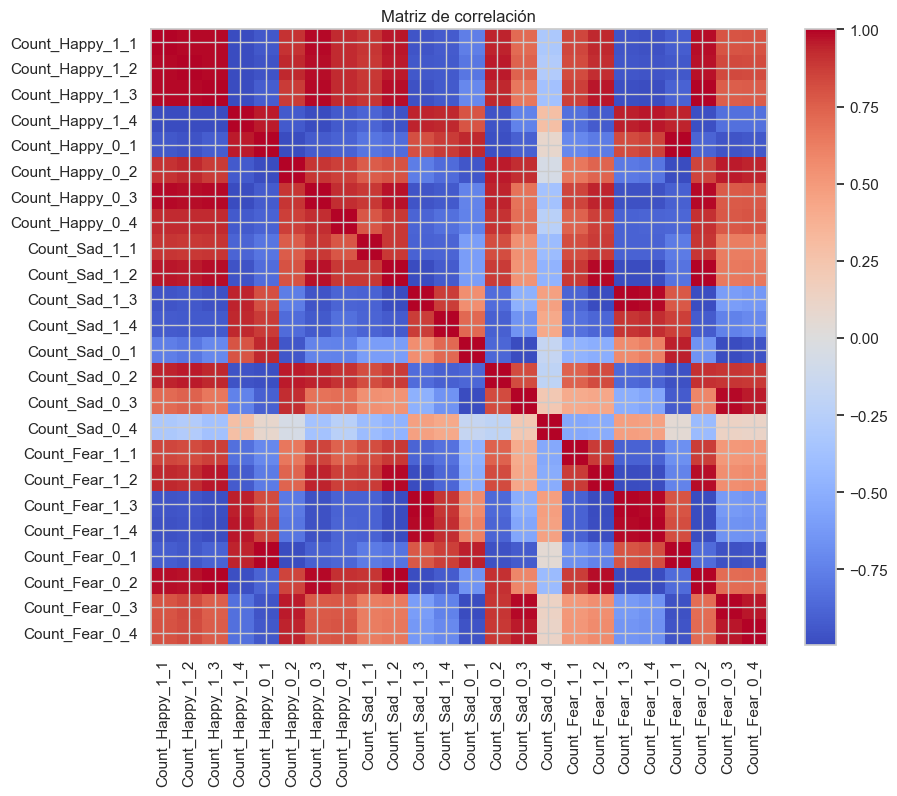

In [40]:
correlation_matrix = df_transformed_data.corr()
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Matriz de correlación')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()


## Clustering on Transformed Data

#### Hierarchical Clustering

In [41]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering

                
silhouette = []
db = []
for n in range(2,20):
    clustering = AgglomerativeClustering(n_clusters=n,linkage="complete").fit(df_transformed_data)
    silhouette.append(silhouette_score(df_transformed_data, clustering.labels_))
    db.append(davies_bouldin_score(df_transformed_data, clustering.labels_))



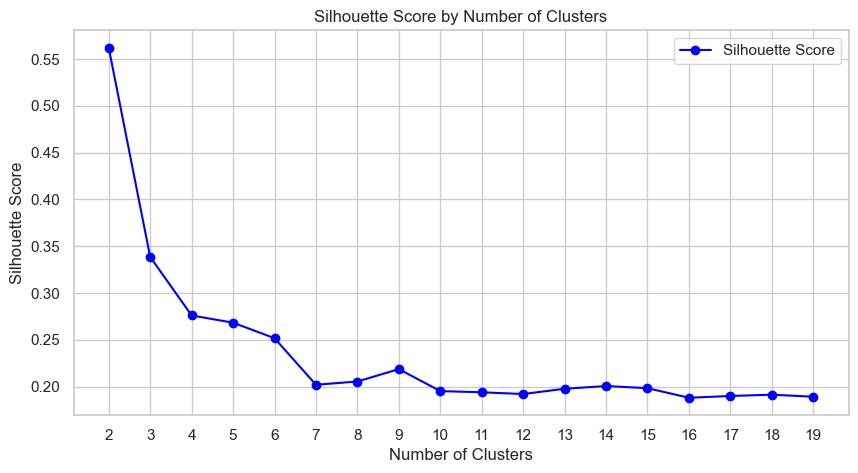

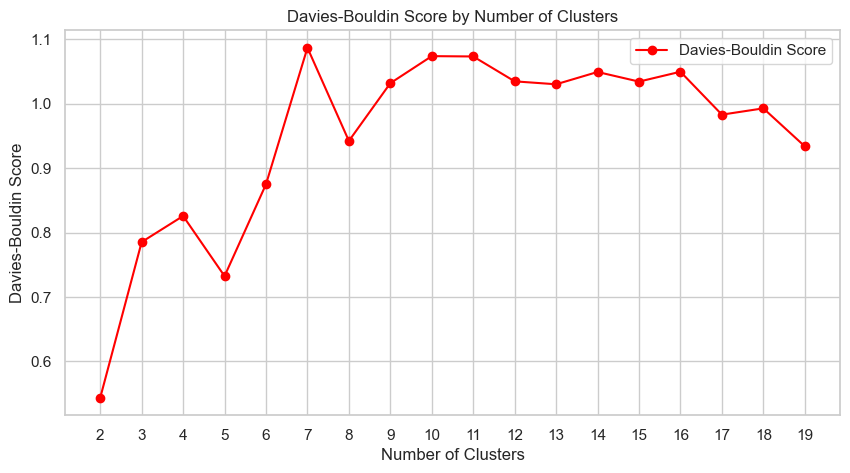

In [42]:
import matplotlib.pyplot as plt

# Assuming silhouette and db lists are filled with scores for cluster numbers from 2 to 11
cluster_range = range(2, 20)

# Plotting the silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette, marker='o', linestyle='-', color='blue', label='Silhouette Score')
plt.title('Silhouette Score by Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.xticks(cluster_range)
plt.show()

# Plotting the Davies-Bouldin scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, db, marker='o', linestyle='-', color='red', label='Davies-Bouldin Score')
plt.title('Davies-Bouldin Score by Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.legend()
plt.grid(True)
plt.xticks(cluster_range)
plt.show()

###### Create Excel

In [43]:
for n in range(2, 10):
    clustering = AgglomerativeClustering(n_clusters=n, linkage="complete").fit(df_transformed_data)
    export_df = baseline.copy()
    export_df["clusters"] = clustering.labels_
    export_df = export_df[["Subject ID", "clusters"]]
    export_df.columns = ["EPRIME_CODE", "clusters"]
    name_excel = f'Clusters_Counts/Hierarchical_Clusters/counts_predictive_processing_hierarchical_{n}_clusters.xlsx'
    export_df.to_excel(name_excel, index=False)


In [44]:
sns.set(style="whitegrid")

for n in range(2,7):
    
    name_output = f"count_hierarchical_{n}_clusters.docx"
    
    clustering = AgglomerativeClustering(n_clusters=n,linkage="complete").fit(df_transformed_data)
    copy_baseline = baseline.copy()
    copy_baseline["clusters"] = clustering.labels_
    
    new_data = pd.merge(scales.copy(),copy_baseline[["Subject ID", "clusters"]].copy(), right_on='Subject ID', left_on='EPRIME_CODE')
    new_data.drop("Subject ID",axis=1,inplace=True)
    numeric_columns = new_data.select_dtypes(include=[np.number]).columns
    columns_to_select = ['EPRIME_CODE'] + list(numeric_columns) + ["ERQ_ES"] + ["UPPSP_PMD"]
    
    # Selecting all numeric columns along with "Subject"
    filtered_df = new_data[columns_to_select]
    cols_to_drop = filtered_df.columns[filtered_df.isnull().sum() > 50]
    filtered_df = filtered_df.drop(columns=cols_to_drop).copy()
    filtered_df.drop("Age", axis=1, inplace=True)
    
    
    doc = Document()
    size_clust = np.unique(copy_baseline["clusters"], return_counts=True)[1]
    
    for idx, group in enumerate(list_metrics):
        # Add group name to the document
        doc.add_paragraph(f"Group {idx + 1}: {', '.join(group)}")
    
        # Select columns belonging to the group
        columns_to_plot = ['clusters'] + group
        group_df = filtered_df[columns_to_plot]
    
        # Melt the dataframe
        melted_df = pd.melt(group_df, id_vars=['clusters'], value_vars=group,
                            var_name='Variable', value_name='Mean_Score')
        
        num_cols = len(group)
        for i, variable in enumerate(group):
            # Create a new figure for each variable
            plt.figure(figsize=(8, 6))
            ax = plt.gca()
    
            # Plot boxplot for the current variable
            sns.boxplot(x='clusters', y='Mean_Score', data=melted_df[melted_df['Variable'] == variable], ax=ax)
            ax.set_title(f'Boxplot for {variable}')
            ax.set_xlabel('Clusters')
            ax.set_ylabel('Mean Score')
            ax.grid(True)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
            # Calculate mean
            means = melted_df[melted_df['Variable'] == variable].groupby('clusters')['Mean_Score'].mean()
            stats = melted_df[melted_df['Variable'] == variable].groupby('clusters')['Mean_Score'].agg(['size', 'mean', 'std'])
            
            # Add text annotation for mean below the boxplot
            for cluster, mean in enumerate(means):
                ax.text(cluster, mean, f'{mean:.2f}', ha='center', va='top', color='red')
    
            plt.tight_layout()
            plot_filename = f'plot_{idx}_{i}.png'  # Generate unique filename
            plt.savefig(plot_filename)
            plt.close()
    
            # Generate table for statistics
            stats.reset_index(inplace=True)
            stats["clusters"] = stats["clusters"]
            stats["mean"] = stats["mean"].round(2)
            stats["std"] = stats["std"].round(2)
            stats['SE of Cluster'] = (stats['std'] / np.sqrt(stats['size'])).round(2)
            stats['size'] = size_clust
    
            stats.columns = ["Number of Cluster", "Size of Cluster", "Mean of Cluster", "Standard Deviation of Cluster",
                             "SE of Cluster"]
    
            plt.figure(figsize=(8, 2))
            table = plt.table(cellText=stats.drop("Standard Deviation of Cluster", axis=1).values,
                              colLabels=stats.drop("Standard Deviation of Cluster", axis=1).columns,
                              cellLoc='center',
                              loc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(1, 1)
            table.auto_set_column_width([i for i in range(len(stats.columns))])
            plt.axis('off')
            plt.title(f'Statistics for {variable}')
            table_filename = f'table_{idx}_{i}.png'  # Generate unique filename
            plt.savefig(table_filename)
            plt.close()
            
                # Add plot and table to the Word document in the same row
            table_cell = doc.add_table(rows=1, cols=2)
            table_row = table_cell.rows[0]
            cell1 = table_row.cells[0]
            cell2 = table_row.cells[1]
            
            cell1.paragraphs[0].add_run().add_picture(plot_filename, width=Inches(3))  # Adjust width as needed
            cell2.paragraphs[0].add_run().add_picture(table_filename, width=Inches(3))  # Adjust width as 
    doc.save(name_output)


###### Look Metrics

In [45]:
clustering = AgglomerativeClustering(n_clusters=2,linkage="complete").fit(df_transformed_data)
copy_baseline = baseline.copy()
copy_baseline["clusters"] = clustering.labels_
cluster_hierarchical = create_metrics_cluster_df(copy_baseline[["Subject ID","clusters"]], scales)
cluster_hierarchical

,PA_mean,NA._mean,ERQ_CR_mean,ERQ_ES_mean,UPPSP_NU_mean,UPPSP_PU_mean,UPPSP_SS_mean,UPPSP_PMD_mean,UPPSP_PSV_mean,BIS_mean,...,ZKPQ_ACT_mean,ZKPQ_SY_mean,ZKPQ_IMPSS_mean,ZKPQ_AGG_HOST_mean,ZKPQ_INFREQ_mean,SPQ_mean,SPQ_IR_mean,MSSB_POS_mean,MSSB_NEG_mean,MSSB_DES_mean
0,33.19,20.14,4.92,2.99,8.92,9.85,10.82,7.41,7.05,21.75,...,8.05,7.08,8.8,6.73,1.57,2.23,2.66,1.92,1.89,2.22
1,34.29,22.71,4.43,3.86,8.14,9.86,11.43,7.29,7.00,19.14,...,10.80,7.20,11.0,6.60,1.20,2.00,2.80,2.17,2.17,3.33


In [46]:
create_mean_tasks(pred_data,copy_baseline[["Subject ID","clusters"]])


,Cluster,Happy_0,Happy_1,Sad_0,Sad_1,Fear_0,Fear_1
0,0.0,1.188967,3.449139,1.719484,2.798122,1.784038,2.735524
1,1.0,1.714286,2.857143,1.904762,2.190476,2.214286,2.238095


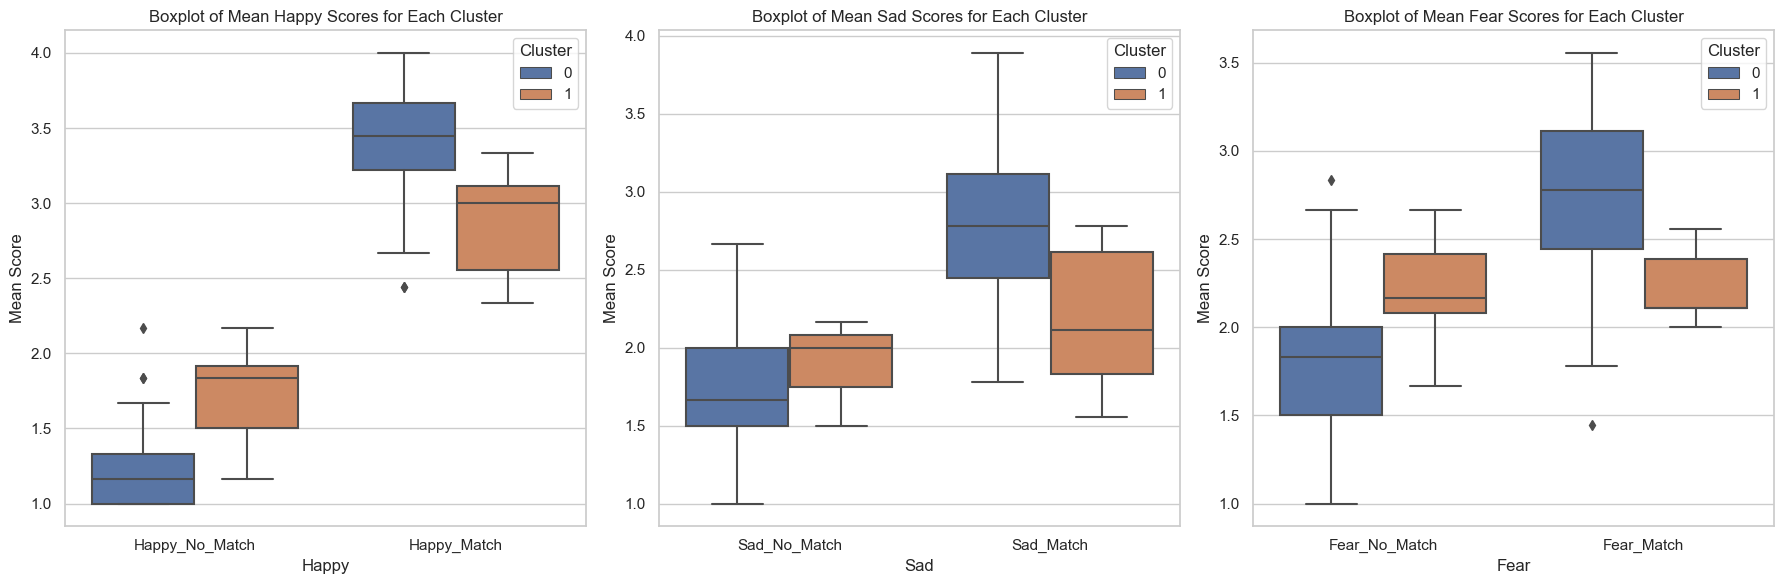

In [47]:
create_boxplots(pred_data,copy_baseline[["Subject ID","clusters"]])


#### OPTICS Clustering

In [48]:
from sklearn.cluster import OPTICS

silhouette = []
db = []

for n in range(2, 8):
    clustering = OPTICS(min_samples=n, metric="euclidean", algorithm="auto").fit(df_transformed_data)
    copy_df = df_transformed_data.copy()
    copy_df = pd.DataFrame(copy_df)

    copy_df["clusters"] = clustering.labels_.copy()
    copy_df = copy_df[copy_df["clusters"] != -1]
    silhouette.append(silhouette_score(copy_df.drop("clusters",axis=1), copy_df["clusters"]))
    db.append(davies_bouldin_score(copy_df.drop("clusters",axis=1), copy_df["clusters"]))


In [49]:
sns.set(style="whitegrid")

for n in range(4,8):
    
    name_output = f"count_OPTICS_{n}_per_clusters.docx"
    
    clustering = OPTICS(min_samples=n, metric="euclidean", algorithm="auto").fit(df_transformed_data)
    copy_baseline = baseline.copy()
    copy_baseline["clusters"] = clustering.labels_
    
    
    new_data = pd.merge(scales.copy(),copy_baseline[["Subject ID", "clusters"]].copy(), right_on='Subject ID', left_on='EPRIME_CODE')
    new_data.drop("Subject ID",axis=1,inplace=True)
    numeric_columns = new_data.select_dtypes(include=[np.number]).columns
    columns_to_select = ['EPRIME_CODE'] + list(numeric_columns) + ["ERQ_ES"] + ["UPPSP_PMD"]
    new_data = new_data[new_data["clusters"] != -1]

    # Selecting all numeric columns along with "Subject"
    filtered_df = new_data[columns_to_select]
    cols_to_drop = filtered_df.columns[filtered_df.isnull().sum() > 50]
    filtered_df = filtered_df.drop(columns=cols_to_drop).copy()
    filtered_df.drop("Age", axis=1, inplace=True)
    
    
    doc = Document()
    size_clust = np.unique(new_data["clusters"], return_counts=True)[1]
    
    for idx, group in enumerate(list_metrics):
        # Add group name to the document
        doc.add_paragraph(f"Group {idx + 1}: {', '.join(group)}")
    
        # Select columns belonging to the group
        columns_to_plot = ['clusters'] + group
        group_df = filtered_df[columns_to_plot]
    
        # Melt the dataframe
        melted_df = pd.melt(group_df, id_vars=['clusters'], value_vars=group,
                            var_name='Variable', value_name='Mean_Score')
        
        num_cols = len(group)
        for i, variable in enumerate(group):
            # Create a new figure for each variable
            plt.figure(figsize=(8, 6))
            ax = plt.gca()
    
            # Plot boxplot for the current variable
            sns.boxplot(x='clusters', y='Mean_Score', data=melted_df[melted_df['Variable'] == variable], ax=ax)
            ax.set_title(f'Boxplot for {variable}')
            ax.set_xlabel('Clusters')
            ax.set_ylabel('Mean Score')
            ax.grid(True)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
            # Calculate mean
            means = melted_df[melted_df['Variable'] == variable].groupby('clusters')['Mean_Score'].mean()
            stats = melted_df[melted_df['Variable'] == variable].groupby('clusters')['Mean_Score'].agg(['size', 'mean', 'std'])
            
            # Add text annotation for mean below the boxplot
            for cluster, mean in enumerate(means):
                ax.text(cluster, mean, f'{mean:.2f}', ha='center', va='top', color='red')
    
            plt.tight_layout()
            plot_filename = f'plot_{idx}_{i}.png'  # Generate unique filename
            plt.savefig(plot_filename)
            plt.close()
    
            # Generate table for statistics
            stats.reset_index(inplace=True)
            stats["clusters"] = stats["clusters"]
            stats["mean"] = stats["mean"].round(2)
            stats["std"] = stats["std"].round(2)
            stats['SE of Cluster'] = (stats['std'] / np.sqrt(stats['size'])).round(2)
            stats['size'] = size_clust
    
            stats.columns = ["Number of Cluster", "Size of Cluster", "Mean of Cluster", "Standard Deviation of Cluster",
                             "SE of Cluster"]
    
            plt.figure(figsize=(8, 2))
            table = plt.table(cellText=stats.drop("Standard Deviation of Cluster", axis=1).values,
                              colLabels=stats.drop("Standard Deviation of Cluster", axis=1).columns,
                              cellLoc='center',
                              loc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(1, 1)
            table.auto_set_column_width([i for i in range(len(stats.columns))])
            plt.axis('off')
            plt.title(f'Statistics for {variable}')
            table_filename = f'table_{idx}_{i}.png'  # Generate unique filename
            plt.savefig(table_filename)
            plt.close()
            
                # Add plot and table to the Word document in the same row
            table_cell = doc.add_table(rows=1, cols=2)
            table_row = table_cell.rows[0]
            cell1 = table_row.cells[0]
            cell2 = table_row.cells[1]
            
            cell1.paragraphs[0].add_run().add_picture(plot_filename, width=Inches(3))  # Adjust width as needed
            cell2.paragraphs[0].add_run().add_picture(table_filename, width=Inches(3))  # Adjust width as 
    doc.save(name_output)


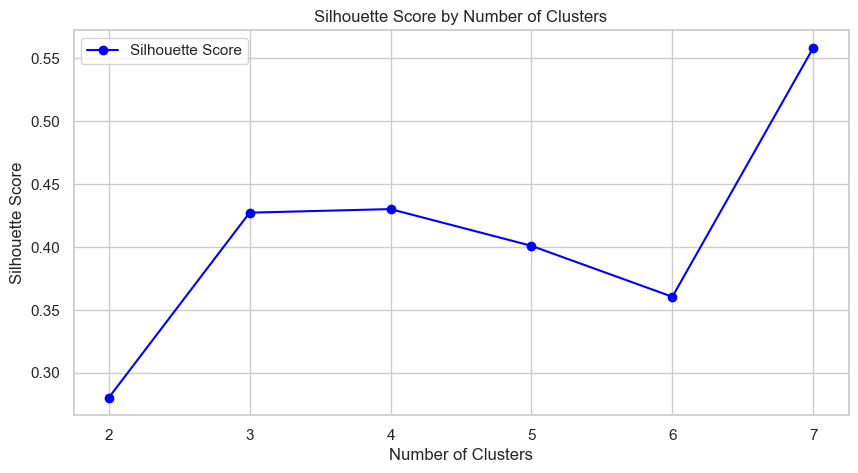

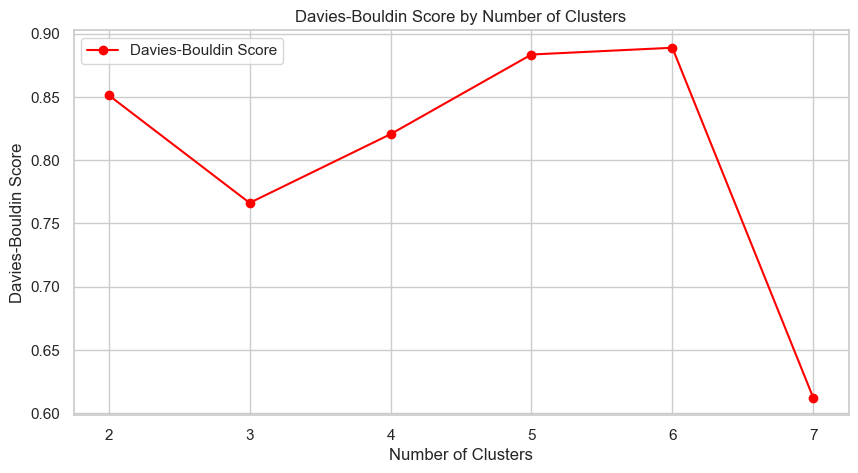

In [50]:
# Assuming silhouette and db lists are filled with scores for cluster numbers from 2 to 11
cluster_range = range(2, 8)

# Plotting the silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette, marker='o', linestyle='-', color='blue', label='Silhouette Score')
plt.title('Silhouette Score by Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.xticks(cluster_range)
plt.show()

# Plotting the Davies-Bouldin scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, db, marker='o', linestyle='-', color='red', label='Davies-Bouldin Score')
plt.title('Davies-Bouldin Score by Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.legend()
plt.grid(True)
plt.xticks(cluster_range)
plt.show()


###### Create Excel

In [51]:
for n in range(2, 8):
    clustering = OPTICS(min_samples=n, metric="euclidean", algorithm="auto").fit(df_transformed_data)
    export_df = baseline.copy()
    export_df["clusters"] = clustering.labels_
    export_df = export_df[["Subject ID", "clusters"]]
    export_df.columns = ["EPRIME_CODE", "clusters"]
    name_excel = f'Clusters_Counts/OPTICS_Clusters/counts_predictive_processing_optics_{n}_subjects_for_cluster.xlsx'
    export_df.to_excel(name_excel, index=False)

###### Look Metrics

In [52]:
#Optics
clustering = OPTICS(min_samples=4, metric="euclidean", algorithm="auto").fit(df_transformed_data)
copy_baseline["clusters"] = clustering.labels_
cluster_optics_4 = create_metrics_cluster_df(copy_baseline[["Subject ID","clusters"]], scales)
cluster_optics_4


,PA_mean,NA._mean,ERQ_CR_mean,ERQ_ES_mean,UPPSP_NU_mean,UPPSP_PU_mean,UPPSP_SS_mean,UPPSP_PMD_mean,UPPSP_PSV_mean,BIS_mean,...,ZKPQ_ACT_mean,ZKPQ_SY_mean,ZKPQ_IMPSS_mean,ZKPQ_AGG_HOST_mean,ZKPQ_INFREQ_mean,SPQ_mean,SPQ_IR_mean,MSSB_POS_mean,MSSB_NEG_mean,MSSB_DES_mean
-1,33.22,20.46,4.89,3.04,8.90,9.88,11.07,7.57,7.08,21.73,...,8.45,7.40,9.32,6.67,1.52,2.33,2.65,2.10,1.88,2.42
0,30.80,17.60,4.23,3.10,9.80,9.60,10.60,7.80,7.60,21.20,...,4.00,5.67,8.33,6.33,1.33,1.67,2.00,0.67,2.33,3.00
1,31.50,18.64,5.11,3.20,8.43,9.71,10.29,6.43,6.93,21.14,...,7.11,6.11,7.56,6.33,2.11,2.75,3.83,2.67,1.50,2.50
2,30.80,21.00,4.90,3.40,9.80,9.20,9.80,6.60,7.00,23.20,...,7.33,4.33,6.33,6.00,2.33,0.33,1.00,0.67,2.67,0.33
3,38.89,22.44,4.76,2.56,8.11,9.67,10.00,6.89,6.11,21.44,...,7.00,8.00,8.20,7.00,1.20,1.75,2.50,0.88,2.62,2.50
4,32.20,19.60,5.00,3.35,8.20,9.80,9.80,7.50,7.80,20.80,...,10.75,5.25,9.25,6.50,1.25,2.00,2.00,2.33,3.00,2.67
5,31.33,18.83,4.61,2.29,10.00,10.00,9.17,9.00,8.33,20.67,...,6.33,10.00,5.00,8.50,1.33,1.17,1.17,0.50,1.67,1.17
6,36.60,21.20,5.47,3.40,8.80,10.80,14.00,6.20,5.60,22.00,...,11.67,6.00,12.33,8.67,1.33,2.80,4.00,2.20,1.00,0.80


In [53]:
create_mean_tasks(pred_data,copy_baseline[["Subject ID","clusters"]])


,Cluster,Happy_0,Happy_1,Sad_0,Sad_1,Fear_0,Fear_1
0,-1.0,1.248333,3.410000,1.758333,2.764444,1.813333,2.696667
1,5.0,1.194444,3.148148,1.777778,2.648148,2.027778,2.592593
2,0.0,1.200000,3.400000,1.633333,2.755556,1.766667,2.688889
3,3.0,1.111111,3.654321,1.703704,2.938272,1.888889,3.185185
4,4.0,1.166667,3.555556,1.900000,2.400000,1.566667,2.688889
5,2.0,1.100000,3.600000,1.700000,3.088889,1.633333,2.666667
6,1.0,1.166667,3.317460,1.559524,2.674603,1.833333,2.515873
7,6.0,1.033333,3.555556,1.533333,3.044444,1.566667,2.955556


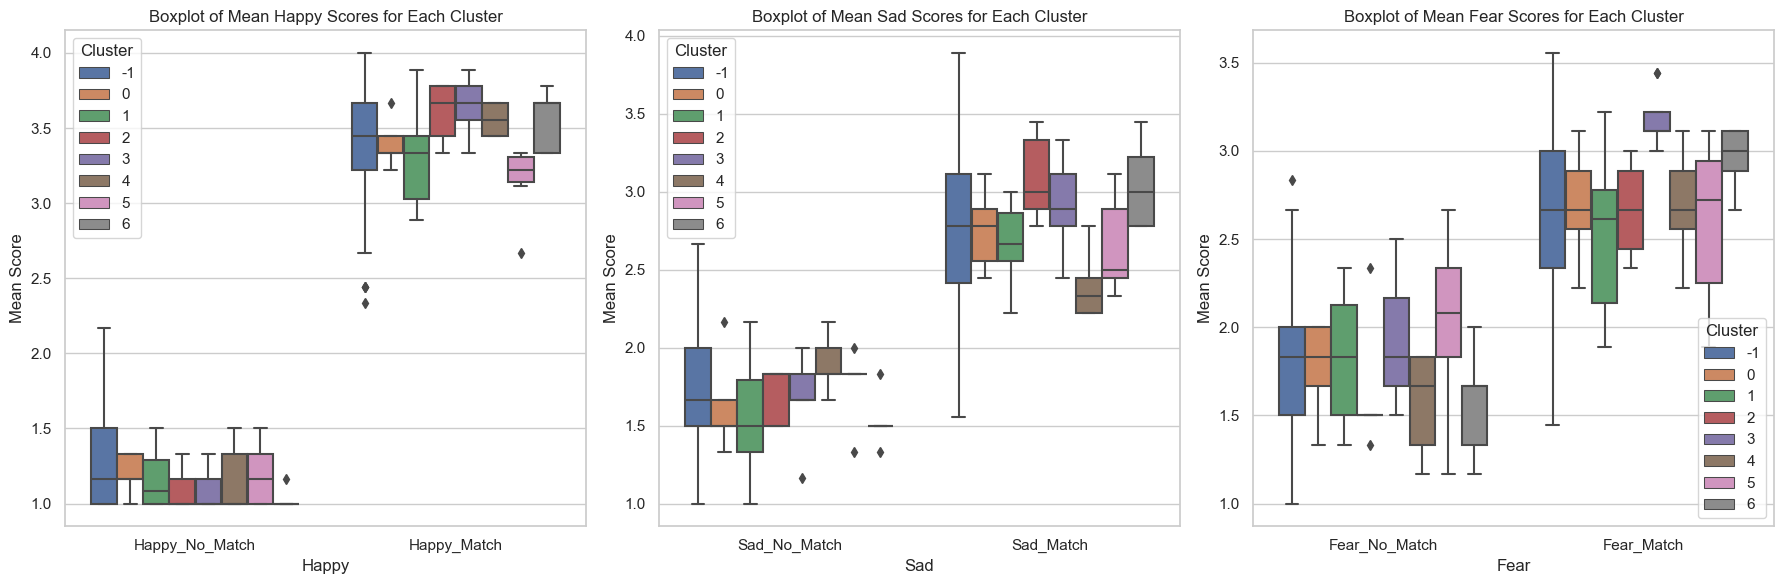

In [54]:
create_boxplots(pred_data,copy_baseline[["Subject ID","clusters"]])


#### KMeans Clustering


In [55]:
from sklearn.cluster import KMeans


silhouette = []
db = []
for n in range(2,20):
    clustering = KMeans(n_clusters=n,init = "k-means++").fit(df_transformed_data)
    silhouette.append(silhouette_score(df_transformed_data, clustering.labels_))
    db.append(davies_bouldin_score(df_transformed_data, clustering.labels_))

C:\Users\manue\anaconda3\envs\CASLabv2\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\manue\anaconda3\envs\CASLabv2\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\manue\anaconda3\envs\CASLabv2\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\manue\anaconda3\envs\CASLabv2\lib\site-packages\sklearn\cluster\_kmeans.py:1436: User

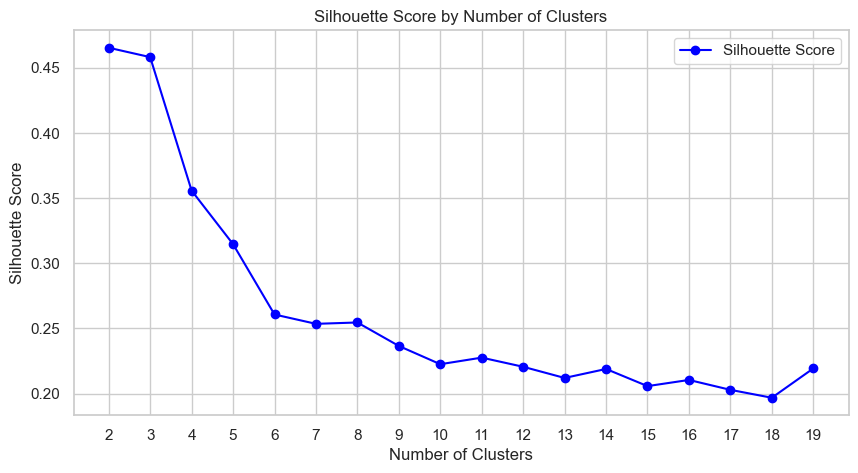

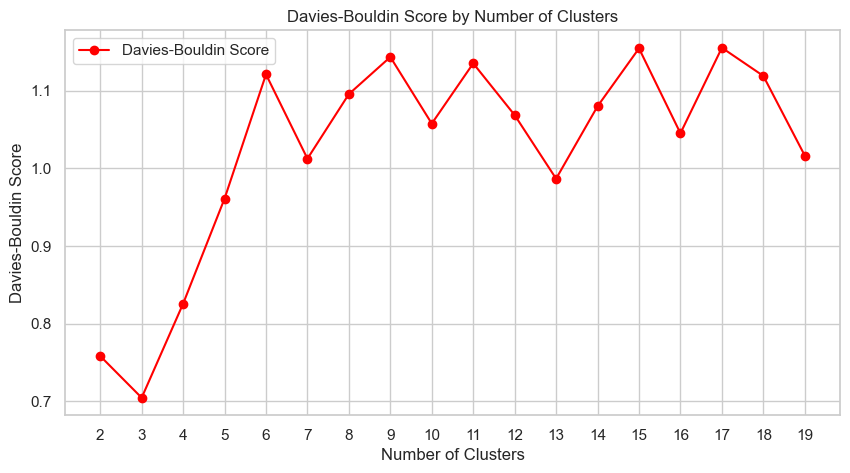

In [56]:
# Assuming silhouette and db lists are filled with scores for cluster numbers from 2 to 11
cluster_range = range(2, 20)

# Plotting the silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette, marker='o', linestyle='-', color='blue', label='Silhouette Score')
plt.title('Silhouette Score by Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.xticks(cluster_range)
plt.show()

# Plotting the Davies-Bouldin scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, db, marker='o', linestyle='-', color='red', label='Davies-Bouldin Score')
plt.title('Davies-Bouldin Score by Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.legend()
plt.grid(True)
plt.xticks(cluster_range)
plt.show()

In [57]:
clustering = KMeans(n_clusters=3,init="k-means++").fit(df_transformed_data)
copy_baseline["clusters"] = clustering.labels_
cluster_kmeans = create_metrics_cluster_df(copy_baseline[["Subject ID","clusters"]], scales)
cluster_kmeans


C:\Users\manue\anaconda3\envs\CASLabv2\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,PA_mean,NA._mean,ERQ_CR_mean,ERQ_ES_mean,UPPSP_NU_mean,UPPSP_PU_mean,UPPSP_SS_mean,UPPSP_PMD_mean,UPPSP_PSV_mean,BIS_mean,...,ZKPQ_ACT_mean,ZKPQ_SY_mean,ZKPQ_IMPSS_mean,ZKPQ_AGG_HOST_mean,ZKPQ_INFREQ_mean,SPQ_mean,SPQ_IR_mean,MSSB_POS_mean,MSSB_NEG_mean,MSSB_DES_mean
0,32.46,19.89,4.83,2.93,9.08,9.76,10.46,7.49,7.42,21.69,...,8.10,7.11,8.92,6.85,1.69,2.25,2.59,1.92,1.82,2.21
1,33.97,20.43,5.01,3.04,8.72,9.91,11.19,7.33,6.64,21.79,...,8.08,7.00,8.62,6.59,1.44,2.21,2.74,1.92,1.96,2.23
2,34.38,22.25,4.50,3.94,8.50,10.25,11.62,7.25,7.00,19.62,...,9.67,7.50,10.83,6.50,1.17,2.00,2.80,2.17,2.17,3.33


In [58]:
create_mean_tasks(pred_data,copy_baseline[["Subject ID","clusters"]])

,Cluster,Happy_0,Happy_1,Sad_0,Sad_1,Fear_0,Fear_1
0,1.0,1.126866,3.575456,1.733831,3.056385,1.746269,2.950249
1,0.0,1.238739,3.339339,1.709459,2.572072,1.817568,2.546547
2,2.0,1.708333,2.888889,1.854167,2.194444,2.166667,2.250000


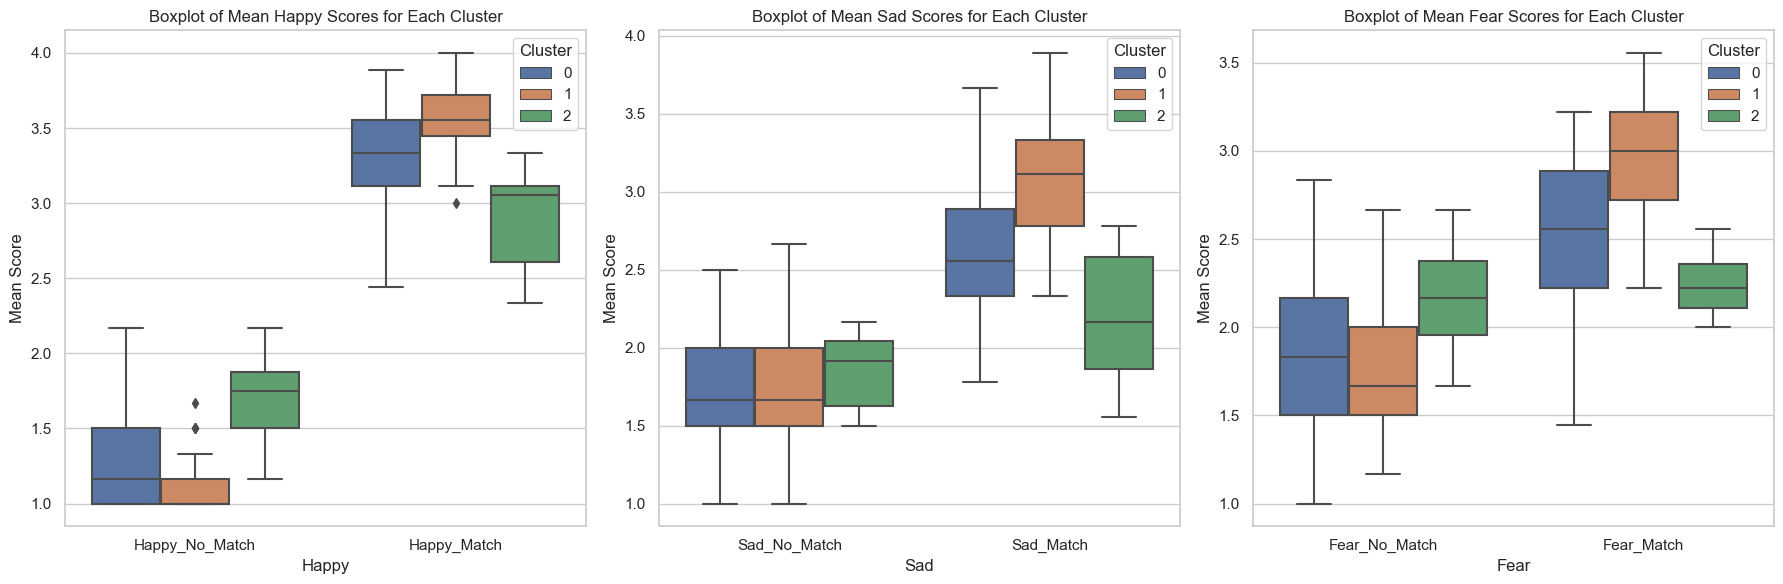

In [59]:
create_boxplots(pred_data,copy_baseline[["Subject ID","clusters"]])